# **3. Direct Methods**

Les Direct Methods désignent une famille de techniques de deep learning capables de traiter directement les nuages de points 3D sans passer par des représentations intermédiaires (voxels, maillages ou projections 2D).
L’idée principale est d’apprendre à partir des coordonnées brutes des points, ce qui permet de préserver l’information géométrique originale et de réduire les pertes liées aux conversions de format.

Dans le cadre de ce travail, nous avons adopté une approche fondée sur :

l’échantillonnage par FPS (Farthest Point Sampling), qui sélectionne un nombre fixe de points représentatifs du nuage, garantissant une bonne couverture géométrique ;

deux modèles de référence pour l’analyse des nuages de points : PointNet et Dynamic Graph Convolutional Neural Network (DGCNN).

Ces méthodes apprennent automatiquement des représentations discriminantes directement depuis les données 3D, et constituent aujourd’hui des baselines incontournables pour la classification d’objets dans les nuages de points.



> Montage du Google Drive et Initialisation des Chemins:



In [1]:
from pathlib import Path
from google.colab import drive
drive.mount('/content/drive')

ROOT   = Path("/content/drive/MyDrive/trees_dataset")
PREP   = ROOT / "data_preprocessed"      # contient train/ et test/ avec *_norm.ply

CLASSES = ["Beech","Red_Oak","Ash","Oak","Douglas_Fir","Spruce","Pine"]

print("ROOT:", ROOT.exists(), " PREP:", PREP.exists())

Mounted at /content/drive
ROOT: True  PREP: True




> Chargement flexible des .PLY + DataLoaders + Sanity-check PointNet (Colab):



installer les dépendances, monte Google Drive, parcourt automatiquement vos dossiers Dataset_/dataset_train|dataset_test/<Classe>/*.ply (noms de fichiers libres), normalise/échantillonne chaque nuage (→ 2048 points), crée des DataLoaders avec augmentation optionnelle, fournit une analyse de dataset (comptages et aperçus), puis instancie un SimplePointNet et effectue un forward test pour valider le pipeline avant entraînement.

In [2]:
# Colab: dépendances
%pip -q install open3d==0.19.0 torch --upgrade

import os, json, math, random
from pathlib import Path
from typing import List, Tuple, Dict, Optional

import numpy as np
import open3d as o3d
import torch
from torch.utils.data import Dataset, DataLoader


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 447.7/447.7 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 96.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.8/139.8 kB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 56.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 68.3 MB/s eta 0:00:00


In [ ]:
# ============================== SCRIPT POUR N'IMPORTE QUEL NOM DE FICHIER PLY ==============================
from pathlib import Path
from google.colab import drive
import numpy as np
import open3d as o3d
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score
import random
import time

# Mount Google Drive
drive.mount('/content/drive')

# Chemins corrigés
ROOT = Path("/content/drive/MyDrive/trees_dataset")
DATASET_DIR = ROOT / "Dataset_"  # contient dataset_train/ et dataset_test/
CLASSES = ["beech", "Red_Oak", "Ash", "Oak", "douglas_fir", "spruce", "pine"]

print("ROOT:", ROOT.exists())
print("DATASET_DIR:", DATASET_DIR.exists())
print("Train exists:", (DATASET_DIR / "dataset_train").exists())
print("Test exists:", (DATASET_DIR / "dataset_test").exists())

# ============================== PROCESSOR OPTIMISÉ ==============================

class PLYProcessor:
    def __init__(self, target_points=2048):
        self.target_points = target_points

    def process_ply(self, ply_path):
        """Charge et process un fichier PLY rapidement - accepte tous les noms"""
        try:
            pcd = o3d.io.read_point_cloud(str(ply_path))
            points = np.asarray(pcd.points).astype(np.float32)

            if len(points) == 0:
                print(f"⚠️  Fichier vide: {ply_path.name}")
                return self._generate_dummy_points()

            # Normalisation
            centroid = np.mean(points, axis=0)
            points = points - centroid
            max_dist = np.max(np.sqrt(np.sum(points**2, axis=1)))
            if max_dist > 1e-6:
                points = points / max_dist

            # Échantillonnage à taille fixe
            return self._sample_to_fixed_size(points)

        except Exception as e:
            print(f"❌ Erreur avec {ply_path.name}: {e}")
            return self._generate_dummy_points()

    def _sample_to_fixed_size(self, points):
        n_points = len(points)

        if n_points >= self.target_points:
            # Sur-échantillonnage: selection aléatoire
            indices = np.random.choice(n_points, self.target_points, replace=False)
            return points[indices]
        else:
            # Sous-échantillonnage: repetition avec bruit
            repeat_count = (self.target_points // n_points) + 1
            repeated = np.tile(points, (repeat_count, 1))
            indices = np.random.choice(len(repeated), self.target_points, replace=False)
            sampled = repeated[indices]

            # Petit bruit pour éviter les duplicates exacts
            noise = np.random.normal(0, 0.001, sampled.shape).astype(np.float32)
            return sampled + noise

    def _generate_dummy_points(self):
        """Points factices en cas d'erreur"""
        return np.random.normal(0, 0.1, (self.target_points, 3)).astype(np.float32)

# ============================== DATASET FLEXIBLE ==============================

class FlexibleTreeDataset(Dataset):
    def __init__(self, data_dir, class_names, target_points=2048, augment=False):
        self.data_dir = Path(data_dir)
        self.class_names = class_names
        self.target_points = target_points
        self.augment = augment
        self.processor = PLYProcessor(target_points)

        self.samples = []  # Liste des (chemin, label)

        self._discover_samples()
        print(f"📁 {self.data_dir.name}: {len(self.samples)} samples chargés")

    def _discover_samples(self):
        """Découverte automatique de tous les fichiers PLY - peu importe le nom"""
        for class_idx, class_name in enumerate(self.class_names):
            class_dir = self.data_dir / class_name
            if class_dir.exists():
                # Recherche de TOUS les fichiers PLY, peu importe le nom
                ply_files = list(class_dir.glob("*.ply"))

                if not ply_files:
                    print(f"   {class_name}: ❌ Aucun fichier .ply trouvé")
                    continue

                for ply_file in ply_files:
                    self.samples.append((ply_file, class_idx))

                print(f"   {class_name}: {len(ply_files)} fichiers (.ply)")

                # Affiche quelques noms de fichiers pour vérification
                sample_names = [f.name for f in ply_files[:3]]  # Premier 3 fichiers
                print(f"        Exemples: {sample_names}")
                if len(ply_files) > 3:
                    print(f"        ... et {len(ply_files) - 3} autres")

            else:
                print(f"   {class_name}: ❌ Dossier non trouvé: {class_dir}")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        ply_path, label = self.samples[idx]

        # Processing du point cloud
        points = self.processor.process_ply(ply_path)

        # Augmentation si demandé
        if self.augment:
            points = self._apply_augmentation(points)

        return torch.from_numpy(points).float(), torch.tensor(label)

    def _apply_augmentation(self, points):
        """Applique une augmentation aléatoire"""
        # Rotation
        angle = random.uniform(0, 2 * np.pi)
        cos_a, sin_a = np.cos(angle), np.sin(angle)
        rotation_matrix = np.array([
            [cos_a, -sin_a, 0],
            [sin_a, cos_a, 0],
            [0, 0, 1]
        ], dtype=np.float32)
        points = points @ rotation_matrix.T

        # Scaling
        scale = random.uniform(0.9, 1.1)
        points = points * scale

        # Translation légère
        translation = np.random.uniform(-0.02, 0.02, 3)
        points = points + translation

        # Bruit
        noise = np.random.normal(0, 0.002, points.shape).astype(np.float32)
        return points + noise

# ============================== CHARGEUR DE DONNÉES FLEXIBLE ==============================

def create_flexible_dataloaders(dataset_dir, class_names, batch_size=16, target_points=2048):
    """Crée les dataloaders pour train et test - compatible tous noms de fichiers"""
    train_dir = dataset_dir / "dataset_train"
    test_dir = dataset_dir / "dataset_test"

    print("🔍 Vérification de la structure...")
    print(f"Train directory: {train_dir.exists()}")
    print(f"Test directory: {test_dir.exists()}")

    if not train_dir.exists():
        raise ValueError(f"❌ Dossier train non trouvé: {train_dir}")
    if not test_dir.exists():
        raise ValueError(f"❌ Dossier test non trouvé: {test_dir}")

    # Création des datasets flexibles
    train_dataset = FlexibleTreeDataset(
        train_dir, class_names, target_points, augment=True
    )

    test_dataset = FlexibleTreeDataset(
        test_dir, class_names, target_points, augment=False
    )

    # Vérification qu'on a des données
    if len(train_dataset) == 0:
        raise ValueError("❌ Aucune donnée d'entraînement trouvée!")
    if len(test_dataset) == 0:
        raise ValueError("❌ Aucune donnée de test trouvée!")

    # Création des dataloaders
    train_loader = DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True,
        num_workers=2, pin_memory=True
    )

    test_loader = DataLoader(
        test_dataset, batch_size=batch_size, shuffle=False,
        num_workers=1, pin_memory=True
    )

    return train_loader, test_loader, train_dataset, test_dataset

# ============================== ANALYSE COMPLÈTE ==============================

def analyze_flexible_dataset(dataset_dir, class_names):
    """Analyse complète qui fonctionne avec tous les noms de fichiers"""
    dataset_dir = Path(dataset_dir)

    print("🔍 ANALYSE COMPLÈTE DU DATASET (FLEXIBLE)")
    print("=" * 60)

    for split in ["dataset_train", "dataset_test"]:
        split_dir = dataset_dir / split
        print(f"\n📂 {split}:")

        if not split_dir.exists():
            print("   ❌ Dossier non trouvé")
            continue

        total_samples = 0
        for class_name in class_names:
            class_dir = split_dir / class_name
            if class_dir.exists():
                # Recherche de TOUS les fichiers PLY
                ply_files = list(class_dir.glob("*.ply"))
                total_samples += len(ply_files)

                if ply_files:
                    print(f"   {class_name}: {len(ply_files):3d} fichiers")
                    # Affiche quelques noms pour vérification
                    for i, ply_file in enumerate(ply_files[:2]):  # Premier 2 fichiers
                        try:
                            pcd = o3d.io.read_point_cloud(str(ply_file))
                            points = np.asarray(pcd.points)
                            print(f"        {ply_file.name} -> {len(points):6d} points")
                        except Exception as e:
                            print(f"        {ply_file.name} -> ❌ Erreur: {e}")
                    if len(ply_files) > 2:
                        print(f"        ... {len(ply_files) - 2} autres fichiers")
                else:
                    print(f"   {class_name}: ❌ Aucun fichier .ply")
            else:
                print(f"   {class_name}: ❌ Dossier non trouvé")

        print(f"   TOTAL: {total_samples} fichiers .py")

# ============================== MODÈLE POINTNET ==============================

class SimplePointNet(torch.nn.Module):
    def __init__(self, num_classes=7):
        super().__init__()

        self.conv1 = torch.nn.Conv1d(3, 64, 1)
        self.conv2 = torch.nn.Conv1d(64, 128, 1)
        self.conv3 = torch.nn.Conv1d(128, 1024, 1)

        self.bn1 = torch.nn.BatchNorm1d(64)
        self.bn2 = torch.nn.BatchNorm1d(128)
        self.bn3 = torch.nn.BatchNorm1d(1024)

        self.fc1 = torch.nn.Linear(1024, 512)
        self.fc2 = torch.nn.Linear(512, 256)
        self.fc3 = torch.nn.Linear(256, num_classes)

        self.dropout = torch.nn.Dropout(0.3)

    def forward(self, x):
        # x shape: [B, N, 3] -> [B, 3, N] pour les conv1d
        x = x.transpose(1, 2)

        x = torch.relu(self.bn1(self.conv1(x)))
        x = torch.relu(self.bn2(self.conv2(x)))
        x = torch.relu(self.bn3(self.conv3(x)))

        x = torch.max(x, 2)[0]  # Global max pooling [B, 1024]

        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)

        return x

# ============================== UTILISATION PRINCIPALE ==============================

def main():
    # 1. Analyse du dataset
    print("🚀 Analyse de la structure du dataset...")
    analyze_flexible_dataset(DATASET_DIR, CLASSES)

    # 2. Création des dataloaders
    print("\n📦 Création des dataloaders flexibles...")
    try:
        train_loader, test_loader, train_dataset, test_dataset = create_flexible_dataloaders(
            DATASET_DIR, CLASSES, batch_size=16, target_points=2048
        )

        print(f"\n✅ Datasets créés avec succès!")
        print(f"   Train samples: {len(train_dataset)}")
        print(f"   Test samples:  {len(test_dataset)}")
        print(f"   Batch size:    16")
        print(f"   Points/sample: 2048")

        # 3. Vérification d'un batch
        print("\n🔍 Vérification d'un batch de train...")
        for batch_idx, (points, labels) in enumerate(train_loader):
            print(f"   Batch {batch_idx}: points {points.shape}, labels {labels.tolist()}")
            if batch_idx >= 1:  # Juste le premier batch pour vérification
                break

        # 4. Initialisation du modèle
        print("\n🎯 Initialisation du modèle...")
        model = SimplePointNet(num_classes=len(CLASSES))
        print(f"   Paramètres: {sum(p.numel() for p in model.parameters()):,}")

        # 5. Test de forward pass
        print("\n🧪 Test de forward pass...")
        test_points, test_labels = next(iter(train_loader))
        with torch.no_grad():
            output = model(test_points)
            print(f"   Input shape:  {test_points.shape}")
            print(f"   Output shape: {output.shape}")
            print(f"   Predictions:  {torch.argmax(output, dim=1).tolist()}")
            print(f"   True labels:  {test_labels.tolist()}")

        print(f"\n🎉 Tout est prêt pour l'entraînement!")

    except Exception as e:
        print(f"❌ Erreur lors de la création des dataloaders: {e}")
        print("Vérifiez la structure de vos dossiers:")
        print("Dataset_/dataset_train/Beech/*.ply")
        print("Dataset_/dataset_test/Beech/*.ply")
        print("etc...")

# ============================== EXÉCUTION ==============================

if __name__ == "__main__":
    main()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
ROOT: True
DATASET_DIR: True
Train exists: True
Test exists: True
🚀 Analyse de la structure du dataset...
🔍 ANALYSE COMPLÈTE DU DATASET (FLEXIBLE)

📂 dataset_train:
   beech: ❌ Aucun fichier .ply
   Red_Oak: ❌ Aucun fichier .ply
   Ash: ❌ Aucun fichier .ply
   Oak: ❌ Aucun fichier .ply
   douglas_fir: ❌ Aucun fichier .ply
   spruce: ❌ Aucun fichier .ply
   pine: ❌ Aucun fichier .ply
   TOTAL: 0 fichiers .py

📂 dataset_test:
   beech: ❌ Aucun fichier .ply
   Red_Oak: ❌ Aucun fichier .ply
   Ash: ❌ Aucun fichier .ply
   Oak: ❌ Aucun fichier .ply
   douglas_fir: ❌ Aucun fichier .ply
   spruce: ❌ Aucun fichier .ply
   pine: ❌ Aucun fichier .ply
   TOTAL: 0 fichiers .py

📦 Création des dataloaders flexibles...
🔍 Vérification de la structure...
Train directory: True
Test directory: True
   beech: ❌ Aucun fichier .ply trouvé
   Red_Oak: ❌ Aucun fichier .ply trouvé
 

In [3]:
# ============================== SCRIPT DE DÉCOUVERTE AUTOMATIQUE ==============================
from pathlib import Path
from google.colab import drive
import numpy as np
import open3d as o3d
import torch
from torch.utils.data import Dataset, DataLoader
import random

# Mount Google Drive
drive.mount('/content/drive')

ROOT = Path("/content/drive/MyDrive/trees_dataset")
DATASET_DIR = ROOT / "Dataset_"

print("🔍 Exploration de la structure réelle du dataset...")

# ============================== DÉCOUVERTE AUTOMATIQUE ==============================

def discover_real_structure(dataset_dir):
    """Découvre automatiquement la structure réelle des dossiers"""
    dataset_dir = Path(dataset_dir)

    print("📂 Structure réelle trouvée:")
    print("=" * 50)

    actual_classes = []

    for split in ["dataset_train", "dataset_test"]:
        split_dir = dataset_dir / split
        if split_dir.exists():
            print(f"\n📁 {split}:")

            # Lister tous les dossiers (classes réelles)
            all_dirs = [d for d in split_dir.iterdir() if d.is_dir()]

            for class_dir in all_dirs:
                print(f"   📂 {class_dir.name}:")

                # Compter les fichiers PLY
                ply_files = list(class_dir.glob("*.ply"))
                print(f"      {len(ply_files)} fichiers .ply")

                # Afficher quelques noms de fichiers
                if ply_files:
                    for i, ply_file in enumerate(ply_files[:3]):
                        try:
                            pcd = o3d.io.read_point_cloud(str(ply_file))
                            points = np.asarray(pcd.points)
                            print(f"      {ply_file.name} -> {len(points)} points")
                        except:
                            print(f"      {ply_file.name} -> ❌ erreur lecture")

                    if len(ply_files) > 3:
                        print(f"      ... et {len(ply_files) - 3} autres")

                # Ajouter aux classes réelles
                if class_dir.name not in actual_classes:
                    actual_classes.append(class_dir.name)

        else:
            print(f"\n❌ {split} n'existe pas")

    return sorted(actual_classes)

def discover_real_structure(dataset_dir):
    dataset_dir = Path(dataset_dir)
    print("📂 Structure réelle trouvée:")
    print("=" * 50)

    actual_classes = []
    extensions = ["*.ply", "*.PLY", "*.pcd", "*.PCD"]

    for split in ["dataset_train", "dataset_test"]:
        split_dir = dataset_dir / split
        if not split_dir.exists():
            print(f"\n❌ {split} n'existe pas")
            continue

        print(f"\n📁 {split}:")
        all_dirs = [d for d in split_dir.iterdir() if d.is_dir()]

        for class_dir in all_dirs:
            print(f"   📂 {class_dir.name}:")
            files = []
            for ext in extensions:
                files.extend(class_dir.glob(ext))

            print(f"      {len(files)} fichiers détectés")
            if files:
                for i, f in enumerate(files[:3]):
                    try:
                        pcd = o3d.io.read_point_cloud(str(f))
                        pts = np.asarray(pcd.points)
                        print(f"      {f.name} -> {len(pts)} points")
                    except:
                        print(f"      {f.name} -> ❌ erreur lecture")
                if len(files) > 3:
                    print(f"      ... et {len(files) - 3} autres")

            if class_dir.name not in actual_classes:
                actual_classes.append(class_dir.name)

    return sorted(actual_classes)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
🔍 Exploration de la structure réelle du dataset...




> Lecture tolérante de fichiers texte de points (.txt / .pts):
définit une fonction robuste pour parser des nuages de points stockés en texte (formats hétérogènes .txt ou .pts).

Il ignore les lignes vides, commentaires ou métadonnées.

Il gère plusieurs séparateurs (espaces, tabulations, virgules, points-virgules).

Il détecte et saute les entêtes fréquentes (par exemple une première ligne contenant uniquement le nombre total de points).

Il sélectionne automatiquement les trois premières colonnes numériques (x, y, z).

En cas d’irrégularité, les lignes sont simplement écartées au lieu de bloquer la lecture.

➡️ Ce module sert de fallback universel pour importer des nuages de points textuels en un tableau numpy (N,3).



In [4]:
import re

def _is_float(tok: str) -> bool:
    try:
        float(tok)
        return True
    except:
        return False

def read_points_text_fallback(path, max_lines=None):
    """
    Lecture tolérante de .txt/.pts arbitraires :
    - ignore lignes vides / commentaires
    - accepte espace/onglet/virgule/point-virgule
    - si >3 colonnes -> prend les 3 premières numériques rencontrées
    - saute les lignes d'entête (ex: 'MANIFEST.TXT', 'Baum9_... - Cloud.txt', compte N en 1ère ligne, etc.)
    """
    pts = []
    with open(path, "r", encoding="utf-8", errors="ignore") as f:
        for i, line in enumerate(f):
            if max_lines and i >= max_lines:
                break
            s = line.strip()
            if not s:
                continue
            # remplace séparateurs courants par espace
            s = s.replace(",", " ").replace(";", " ")
            # lignes manifest / meta : skip brut si pas de float
            if not any(ch.isdigit() for ch in s):
                continue
            toks = s.split()
            # cas 1: 1 seul entier au début (souvent N points) -> on saute
            if len(toks) == 1 and re.fullmatch(r"[+-]?\d+", toks[0]):
                continue

            # on garde les 3 premiers tokens numériques rencontrés
            nums = []
            for t in toks:
                if _is_float(t):
                    nums.append(float(t))
                if len(nums) == 3:
                    break
            if len(nums) >= 3:
                pts.append(nums[:3])
            # sinon : ligne non conforme -> skip
    return np.asarray(pts, dtype=np.float32)




> PointCloudProcessor : lecture, normalisation et mise à taille fixe
Charge un nuage de points depuis Open3D (PLY/PCD…) avec fallback texte (.txt/.pts) tolérant, centre les points, met à l’échelle dans la boule unité et ramène à un nombre fixe (échantillonnage ou répétition + léger bruit). Prêt pour un pipeline d’entraînement.


In [5]:
class PointCloudProcessor:
    """Charge (Open3D ou fallback texte), normalise dans la boule unité, et met à taille fixe."""
    def __init__(self, target_points=2048):
        self.target_points = target_points

    def process_pc(self, path):
        path = str(path)
        pts = None
        # 1) tentative Open3D si extension connue
        try:
            pcd = o3d.io.read_point_cloud(path)
            arr = np.asarray(pcd.points).astype(np.float32)
            if arr.shape[0] >= 16:      # seuil anti-faux positifs (ex: .pts mal lus)
                pts = arr
        except Exception as e:
            # on tombera en fallback texte
            pass

        # 2) fallback texte (utile pour .txt et .pts capricieux)
        if pts is None or pts.shape[0] < 16:
            try:
                arr = read_points_text_fallback(path)
                if arr.shape[0] >= 16:
                    pts = arr
            except Exception as e:
                print(f"❌ Fallback-texte KO pour {path}: {e}")

        if pts is None or pts.shape[0] == 0:
            print(f"⚠️  Fichier vide/non lisible: {path}")
            return self._dummy()

        # Normalisation: centrage + mise à l'échelle unité (max radius)
        pts -= pts.mean(axis=0, keepdims=True)
        r = np.linalg.norm(pts, axis=1).max()
        if r > 1e-6:
            pts /= r

        return self._to_fixed_size(pts)

    def _to_fixed_size(self, pts):
        n = len(pts)
        if n >= self.target_points:
            # échantillonnage simple (tu peux brancher FPS ici si tu veux)
            idx = np.random.choice(n, self.target_points, replace=False)
            return pts[idx]
        rep = (self.target_points // n) + 1
        repeated = np.tile(pts, (rep, 1))
        idx = np.random.choice(len(repeated), self.target_points, replace=False)
        out = repeated[idx]
        noise = np.random.normal(0, 0.001, out.shape).astype(np.float32)
        return out + noise

    def _dummy(self):
        return np.random.normal(0, 0.1, (self.target_points, 3)).astype(np.float32)


In [6]:
def analyze_flexible_dataset(dataset_dir, class_names, max_show_per_class=2):
    dataset_dir = Path(dataset_dir)
    print("🔍 ANALYSE COMPLÈTE DU DATASET (multi-extensions, avec fallback .txt)")
    print("=" * 80)
    for split in ["dataset_train", "dataset_test"]:
        sdir = dataset_dir / split
        print(f"\n📂 {split}: {sdir}")
        if not sdir.exists():
            print("   ❌ dossier introuvable")
            continue

        total = 0
        for cname in class_names:
            cdir = sdir / cname
            if not cdir.exists():
                print(f"   {cname}: ❌ dossier absent")
                continue
            files = []
            for pat in EXTS:
                files.extend(cdir.rglob(pat))
            files = sorted(files)
            n = len(files); total += n

            if n == 0:
                print(f"   {cname}: ❌ aucun fichier")
                continue

            print(f"   {cname}: {n:4d} fichiers")
            shown = 0
            for f in files:
                try:
                    # 1) essai Open3D
                    pcd = o3d.io.read_point_cloud(str(f))
                    pts = np.asarray(pcd.points)
                    if pts.shape[0] < 16:
                        # 2) fallback
                        pts = read_points_text_fallback(str(f))
                    print(f"        {f.name:30s} -> {len(pts):6d} points")
                except Exception as e:
                    print(f"        {f.name:30s} -> ❌ {e}")
                shown += 1
                if shown >= max_show_per_class:
                    break
            if n > shown:
                print(f"        ... {n - shown} autres")
        print(f"   ➜ TOTAL {split}: {total} fichiers")


In [ ]:
ROOT = Path("/content/drive/MyDrive/trees_dataset/Dataset_")
CLASSES = ["beech","Red_Oak","Ash","Oak","douglas_fir","spruce","pine"]
analyze_flexible_dataset(ROOT, CLASSES, max_show_per_class=2)

train_loader, test_loader, train_ds, test_ds = create_flexible_dataloaders(
    ROOT, CLASSES, batch_size=16, target_points=2048
)


🔍 ANALYSE COMPLÈTE DU DATASET (multi-extensions, avec fallback .txt)

📂 dataset_train: /content/drive/MyDrive/trees_dataset/Dataset_/dataset_train
   beech:   11 fichiers
        110.pts                        ->  77913 points
        192.pts                        -> 104950 points
        ... 9 autres
   Red_Oak:   81 fichiers
[Open3D WARNING] Read geometry::PointCloud failed: unknown file extension for /content/drive/MyDrive/trees_dataset/Dataset_/dataset_train/Red_Oak/Baum0 nds_da - Cloud.txt (format: auto).
        Baum0 nds_da - Cloud.txt       ->  97412 points
[Open3D WARNING] Read geometry::PointCloud failed: unknown file extension for /content/drive/MyDrive/trees_dataset/Dataset_/dataset_train/Red_Oak/Baum0_123 nrwl30- Cloud.txt (format: auto).
        Baum0_123 nrwl30- Cloud.txt    ->  81893 points
        ... 79 autres
   Ash:   33 fichiers
        131.pts                        -> 163166 points
        149.pts                        ->  52817 points
        ... 31 autres
   



> NPZPointClouds : Dataset PyTorch pour .npz + DataLoaders
Dataset générique qui lit un fichier .npz (détecte automatiquement les clés X/Y), retourne des tensors (N, P, 3) et (N,), et fournit un helper make_loaders() pour créer rapidement des DataLoaders train/test avec les bons paramètres (shuffle, pin_memory, workers).


In [7]:
# ===== Dataset NPZ (P=2048 déjà normalisés) =====
from torch.utils.data import Dataset, DataLoader
import numpy as np, torch, json
from pathlib import Path

class NPZPointClouds(Dataset):
    def __init__(self, npz_path):
        d = np.load(npz_path, allow_pickle=True)
        Xk = next(k for k in d.keys() if k.lower() in ("x","points","data"))
        yk = next(k for k in d.keys() if k.lower() in ("y","label","labels","targets"))
        self.X = d[Xk].astype(np.float32)  # (N,P,3)
        self.y = d[yk].astype(np.int64)    # (N,)
    def __len__(self): return len(self.X)
    def __getitem__(self, i):
        return torch.from_numpy(self.X[i]), torch.tensor(int(self.y[i]))

def make_loaders(train_npz, test_npz, bs=32, workers=2):
    tr_ds = NPZPointClouds(train_npz)
    te_ds = NPZPointClouds(test_npz)
    tr_dl = DataLoader(tr_ds, batch_size=bs, shuffle=True,  num_workers=workers, pin_memory=True)
    te_dl = DataLoader(te_ds, batch_size=bs, shuffle=False, num_workers=max(1,workers//2), pin_memory=True)
    return tr_ds, te_ds, tr_dl, te_dl




> PointNetSmall : modèle compact de classification 3D


Implémentation légère de PointNet (empilement de Conv1d+BN+ReLU, Global Max Pooling, tête MLP). Conçu pour classer des nuages de points normalisés (entrée (B, P, 3)), avec une sortie logits (B, num_classes). Idéal comme baseline rapide et efficace.

In [8]:
# ===== PointNet compact =====
import torch, torch.nn as nn, torch.nn.functional as F

class PointNetSmall(nn.Module):
    def __init__(self, num_classes: int):
        super().__init__()
        self.feat = nn.Sequential(
            nn.Conv1d(3, 64, 1), nn.BatchNorm1d(64),  nn.ReLU(True),
            nn.Conv1d(64,128,1), nn.BatchNorm1d(128), nn.ReLU(True),
            nn.Conv1d(128,256,1),nn.BatchNorm1d(256), nn.ReLU(True),
            nn.Conv1d(256,512,1),nn.BatchNorm1d(512), nn.ReLU(True),
        )
        self.pool = nn.AdaptiveMaxPool1d(1)
        self.head = nn.Sequential(
            nn.Linear(512,256), nn.ReLU(True), nn.Dropout(0.3),
            nn.Linear(256,num_classes)
        )
    def forward(self, x):          # x: (B,P,3)
        x = x.transpose(1,2)       # (B,3,P)
        f = self.feat(x)           # (B,512,P)
        g = self.pool(f).squeeze(-1) # (B,512)
        return self.head(g)        # (B,C)


In [9]:
# ===== Évaluation détaillée =====
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

def evaluate_saved(best_path, test_npz, classes, device):
    # charge
    ckpt = torch.load(best_path, map_location=device)
    model = PointNetSmall(len(classes)).to(device)
    model.load_state_dict(ckpt["model"]); model.eval()

    _, te_ds, _, te_dl = make_loaders(train_npz=None, test_npz=test_npz, bs=64)
    preds, trues, probs = [], [], []
    with torch.no_grad():
        for xb, yb in te_dl:
            xb = xb.to(device)
            logits = model(xb)
            p = logits.argmax(1).cpu().numpy()
            preds.extend(p.tolist()); trues.extend(yb.numpy().tolist())
            probs.extend(torch.softmax(logits,1).cpu().numpy().tolist())

    print("\n📊 Rapport de classification:")
    print(classification_report(trues, preds, target_names=classes, digits=3, zero_division=0))

    cm = confusion_matrix(trues, preds)
    plt.figure(figsize=(7,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=classes, yticklabels=classes)
    plt.title('Matrice de confusion'); plt.xlabel('Prédit'); plt.ylabel('Vrai'); plt.tight_layout(); plt.show()

    # Top-3 pour inspection rapide
    print("\n🔝 Top-3 par échantillon:")
    for i,(t,p,pr) in enumerate(zip(trues, preds, probs),1):
        top3 = sorted(list(enumerate(pr)), key=lambda z: -z[1])[:3]
        top3 = [(classes[k], float(v)) for k,v in top3]
        print(f"#{i:02d} true={classes[t]:<12} pred={classes[p]:<12} conf={max(pr):.3f}  top3={top3}")


In [10]:
import os, json, math, random, re
from pathlib import Path
from collections import Counter

import numpy as np
import open3d as o3d

# ========= CONFIG =========
ROOT = Path("/content/drive/MyDrive/trees_dataset/Dataset_")  # ton dataset brut
OUT_DIR = ROOT.parent / "preprocessed_"                      # dossier de sortie
OUT_DIR.mkdir(parents=True, exist_ok=True)

CLASSES = ["beech","Red_Oak","Ash","Oak","douglas_fir","spruce","pine"]

TARGET_PER_CLASS = 400   # nb d’échantillons par classe (ajuste ↑ pour plus de volume)
P = 1024                 # nb de points par nuage (FPS → recommandé 1024 pour PointNet)
SEED = 42
random.seed(SEED); np.random.seed(SEED)

# ========= FONCTIONS UTILES =========

def _is_float(tok):
    try: float(tok); return True
    except: return False

def read_points_text_fallback(path):
    pts = []
    with open(path, "r", encoding="utf-8", errors="ignore") as f:
        for line in f:
            s = line.strip()
            if not s: continue
            s = s.replace(",", " ").replace(";", " ")
            if not any(ch.isdigit() for ch in s): continue
            toks = s.split()
            if len(toks)==1 and re.fullmatch(r"[+-]?\d+", toks[0]): continue
            nums=[]
            for t in toks:
                if _is_float(t): nums.append(float(t))
                if len(nums)==3: break
            if len(nums)==3: pts.append(nums)
    return np.asarray(pts, dtype=np.float32)

def load_point_cloud(path):
    pts=None
    try:
        pcd=o3d.io.read_point_cloud(str(path))
        arr=np.asarray(pcd.points).astype(np.float32)
        if arr.shape[0]>=16: pts=arr
    except: pass
    if pts is None or pts.shape[0]<16:
        try:
            arr=read_points_text_fallback(path)
            if arr.shape[0]>=16: pts=arr
        except: pass
    return pts

def normalize_unit_sphere(pts):
    pts=pts-pts.mean(axis=0,keepdims=True)
    r=np.linalg.norm(pts,axis=1).max()
    if r>0: pts=pts/r
    return pts

def fps_numpy(pts, m):
    N=pts.shape[0]
    if m>=N: return np.arange(N)
    centroid=pts.mean(axis=0,keepdims=True)
    dist2=np.sum((pts-centroid)**2,axis=1)
    start=np.argmax(dist2)
    chosen=np.zeros(m,dtype=np.int64); chosen[0]=start
    min_dist2=np.sum((pts-pts[start])**2,axis=1)
    for i in range(1,m):
        idx=np.argmax(min_dist2); chosen[i]=idx
        d2=np.sum((pts-pts[idx])**2,axis=1)
        min_dist2=np.minimum(min_dist2,d2)
    return chosen

def fix_normalize_fps(pts,P):
    pts=normalize_unit_sphere(pts.astype(np.float32))
    if pts.shape[0]>=P:
        idx=fps_numpy(pts,P)
        return pts[idx]
    pad=np.random.choice(pts.shape[0],P-pts.shape[0],replace=True)
    return np.concatenate([pts,pts[pad]],axis=0)

def augment(pts):
    th=np.random.uniform(0,2*np.pi); c,s=np.cos(th),np.sin(th)
    Rz=np.array([[c,-s,0],[s,c,0],[0,0,1]],np.float32)
    pts=pts@Rz.T
    pts*=np.random.uniform(0.95,1.05)
    jitter=np.clip(0.01*np.random.randn(*pts.shape),-0.03,0.03).astype(np.float32)
    return pts+jitter

# ========= PIPELINE =========

def build_split(split_dir, augment_train=False):
    all_X, all_y = [], []
    for cid, cname in enumerate(CLASSES):
        cdir=split_dir/cname
        if not cdir.exists(): continue
        files=[]
        for ext in ("*.ply","*.pcd","*.xyz","*.pts","*.txt",
                    "*.PLY","*.PCD","*.XYZ","*.PTS","*.TXT"):
            files.extend(cdir.rglob(ext))
        if not files: continue

        # Charger tous les nuages
        seeds=[]
        for f in files:
            pts=load_point_cloud(f)
            if pts is None or pts.shape[0]<16: continue
            seeds.append(fix_normalize_fps(pts,P))
        if not seeds: continue
        seeds=np.stack(seeds,axis=0)

        if augment_train:
            need=TARGET_PER_CLASS
        else:
            need=len(seeds)

        gen=[]
        reps=math.ceil(need/len(seeds))
        for _ in range(reps):
            for b in seeds:
                if augment_train: g=augment(b)
                else: g=b
                gen.append(fix_normalize_fps(g,P))
                if len(gen)>=need: break
            if len(gen)>=need: break

        all_X.append(np.stack(gen,axis=0))
        all_y.append(np.full((len(gen),),cid,dtype=np.int64))

        print(f"{cname}: {len(gen)} samples")

    return np.concatenate(all_X,axis=0), np.concatenate(all_y,axis=0)

print("=== BUILD TRAIN (avec augmentation) ===")
Xtr,ytr=build_split(ROOT/"dataset_train", augment_train=True)
print("=== BUILD TEST (sans augmentation) ===")
Xte,yte=build_split(ROOT/"dataset_test", augment_train=False)

# Shuffle train
perm=np.random.permutation(len(Xtr))
Xtr,ytr=Xtr[perm],ytr[perm]

# Save
np.savez_compressed(OUT_DIR/"train_big_7cls.npz", X=Xtr, y=ytr)
np.savez_compressed(OUT_DIR/"test.npz", X=Xte, y=yte)
Path(OUT_DIR/"manifest.json").write_text(json.dumps({"classes":CLASSES},indent=2),encoding="utf-8")

print(f"[TRAIN] {Xtr.shape} dist={Counter(ytr)}")
print(f"[TEST ] {Xte.shape} dist={Counter(yte)}")
print("✅ Sauvé dans", OUT_DIR)


=== BUILD TRAIN (avec augmentation) ===


KeyboardInterrupt: 



> Chargement NPZ prétraités + Manifest

charger les fichiers train/test au format .npz déjà pré-traités (points normalisés, taille fixe), lit les labels et la liste des classes depuis un manifest.json, et affiche un résumé : dimensions des tenseurs, distribution des classes et cohérence des données. Sert de point de départ fiable pour tout entraînement ou expérimentation.


In [11]:
from pathlib import Path
import numpy as np, json
from collections import Counter

PREP = Path("/content/drive/MyDrive/trees_dataset/preprocessed_")
train_npz = PREP/"train_big_7cls.npz"
test_npz  = PREP/"test.npz"
manifest  = PREP/"manifest.json"

dtr = np.load(train_npz, allow_pickle=True)
Xk = next(k for k in dtr.keys() if k.lower() in ("x","points","data"))
yk = next(k for k in dtr.keys() if k.lower() in ("y","label","labels","targets"))
Xtr, ytr = dtr[Xk], dtr[yk]

dte = np.load(test_npz, allow_pickle=True)
Xte, yte = dte[Xk], dte[yk]

classes = json.loads(manifest.read_text(encoding="utf-8"))["classes"]

print(f"[TRAIN] X:{Xtr.shape} y:{ytr.shape} dist={Counter(map(int,ytr))}")
print(f"[TEST ] X:{Xte.shape} y:{yte.shape} dist={Counter(map(int,yte))}")
print("Classes:", classes)
assert Xtr.shape[2]==3 and Xte.shape[2]==3 and len(classes)==7

[TRAIN] X:(2800, 1024, 3) y:(2800,) dist=Counter({2: 400, 4: 400, 6: 400, 1: 400, 0: 400, 5: 400, 3: 400})
[TEST ] X:(68, 1024, 3) y:(68,) dist=Counter({4: 26, 1: 19, 2: 7, 6: 5, 3: 4, 5: 4, 0: 3})
Classes: ['beech', 'Red_Oak', 'Ash', 'Oak', 'douglas_fir', 'spruce', 'pine']




> PointNet-RLA (Final) : Chargement & Paramètres globaux

Ce script définit les chemins vers les datasets NPZ prétraités (train/test + manifest) et configure les hyperparamètres de haut niveau pour l’entraînement de PointNet-RLA :

DO_SEARCH et SEARCH_TRIALS → contrôle du nombre d’essais de recherche d’hyperparamètres (HPO).

BASE_EPOCHS → nombre d’époques de base pour l’entraînement.

K_MAX → valeur maximale de folds pour la validation croisée (CV).

TTA_N → nombre de passes pour le Test-Time Augmentation (robustesse en test).

C’est le point d’entrée configurateur pour exécuter et contrôler les expériences finales avec PointNet-RLA.

In [12]:
# Dans le script final PointNet-RLA
PREP = Path("/content/drive/MyDrive/trees_dataset/preprocessed_3D")
TRAIN_PACK = PREP/"m3_train_big_7cls.npz"      # ✅
TEST_PACK  = PREP/"m3_test.npz"                # ✅
MANIFEST   = PREP/"m3_manifest_big_7cls.json"  # ✅

# Conseils rapides avant run:
DO_SEARCH   = True   # (HPO conseillé si tu as le temps)
SEARCH_TRIALS = 6
BASE_EPOCHS = 60     # + si stable
K_MAX = 5            # CV 5-fold si min par classe le permet
TTA_N = 4            # ou 8


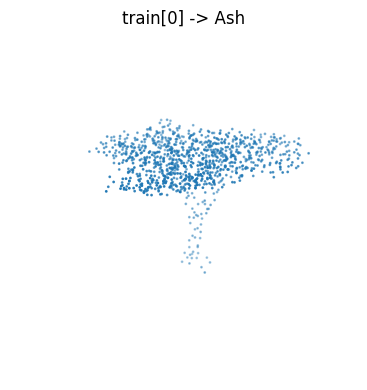

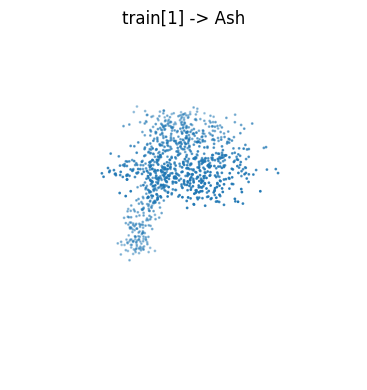

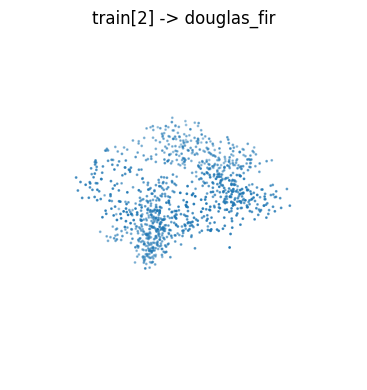

In [13]:
import matplotlib.pyplot as plt
import numpy as np

def show_pc(pts, title=""):
    fig = plt.figure(figsize=(4,4))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(pts[:,0], pts[:,1], pts[:,2], s=1)
    ax.set_title(title); ax.set_axis_off(); plt.tight_layout(); plt.show()

for i in range(3):
    show_pc(Xtr[i], f"train[{i}] -> {classes[int(ytr[i])]}")



> Chargement NPZ + Vérifications de Cohérence

Charge les packs prétraités (train_big_7cls.npz, test.npz) et le manifest (manifest.json), détecte automatiquement les clés X/y, et effectue des vérifications strictes (asserts) sur les formats :

X doit être de forme (N, P, 3) pour train et test,

y de forme (N,),

le manifest doit contenir 7 classes.
Affiche également la distribution des classes (Counter) pour un contrôle rapide avant tout entraînement.

In [14]:
from pathlib import Path
import numpy as np, json
from collections import Counter

PREP = Path("/content/drive/MyDrive/trees_dataset/preprocessed_")  # <<< bien "preprocessed_" !
TRAIN_NPZ = PREP/"train_big_7cls.npz"
TEST_NPZ  = PREP/"test.npz"
MANIFEST  = PREP/"manifest.json"

assert TRAIN_NPZ.exists(), f"missing: {TRAIN_NPZ}"
assert TEST_NPZ.exists(),  f"missing: {TEST_NPZ}"
assert MANIFEST.exists(),  f"missing: {MANIFEST}"

dtr = np.load(TRAIN_NPZ, allow_pickle=True)
Xk  = next(k for k in dtr.keys() if k.lower() in ("x","points","data"))
yk  = next(k for k in dtr.keys() if k.lower() in ("y","label","labels","targets"))
Xtr,ytr = dtr[Xk].astype(np.float32), dtr[yk].astype(np.int64)

dte = np.load(TEST_NPZ, allow_pickle=True)
Xte,yte = dte[Xk].astype(np.float32), dte[yk].astype(np.int64)

classes = json.loads(MANIFEST.read_text())["classes"]
print(f"[TRAIN] X={Xtr.shape} y={ytr.shape} dist={Counter(map(int,ytr))}")
print(f"[TEST ] X={Xte.shape} y={yte.shape} dist={Counter(map(int,yte))}")
print("classes:", classes)
assert Xtr.ndim==3 and Xtr.shape[2]==3, "X train doit être (N,P,3)"
assert Xte.ndim==3 and Xte.shape[2]==3, "X test doit être (N,P,3)"
assert len(classes)==7, "manifest doit contenir 7 classes"


[TRAIN] X=(2800, 1024, 3) y=(2800,) dist=Counter({2: 400, 4: 400, 6: 400, 1: 400, 0: 400, 5: 400, 3: 400})
[TEST ] X=(68, 1024, 3) y=(68,) dist=Counter({4: 26, 1: 19, 2: 7, 6: 5, 3: 4, 5: 4, 0: 3})
classes: ['beech', 'Red_Oak', 'Ash', 'Oak', 'douglas_fir', 'spruce', 'pine']




> NPZ → DataLoaders + PointNetSmall (sanity check)

Crée un Dataset PyTorch minimal (NPZSet) à partir des tableaux NPZ (Xtr, ytr) / (Xte, yte), instancie des DataLoaders (shuffle train, pin_memory, workers adaptés à Colab), définit PointNetSmall (Conv1d+BN+ReLU → Global Max Pool → MLP), puis exécute un forward pass sur un batch pour valider la chaîne données→modèle.

Rôle : vérification rapide de bout en bout avant d’ajouter entraînement, métriques et sauvegardes.


In [15]:
import torch
from torch.utils.data import Dataset, DataLoader

class NPZSet(Dataset):
    def __init__(self, X, y):
        self.X = X.astype(np.float32)
        self.y = y.astype(np.int64)
    def __len__(self): return len(self.X)
    def __getitem__(self, i):
        return torch.from_numpy(self.X[i]), torch.tensor(int(self.y[i]))

bs = 32
num_workers = 0   # <<< IMPORTANT sous Colab si ça “freeze”
pin = True

train_ds = NPZSet(Xtr, ytr)
test_ds  = NPZSet(Xte, yte)
train_loader = DataLoader(train_ds, batch_size=bs, shuffle=True,
                          num_workers=num_workers, pin_memory=pin)
test_loader  = DataLoader(test_ds,  batch_size=bs, shuffle=False,
                          num_workers=num_workers, pin_memory=pin)

print("len(train_ds) =", len(train_ds), " | len(test_ds) =", len(test_ds))
xb, yb = next(iter(train_loader))
print("batch sample:", xb.shape, yb.shape)


len(train_ds) = 2800  | len(test_ds) = 68
batch sample: torch.Size([32, 1024, 3]) torch.Size([32])


In [16]:
import torch.nn as nn, torch.nn.functional as F

class PointNetSmall(nn.Module):
    def __init__(self, C):
        super().__init__()
        self.f = nn.Sequential(
            nn.Conv1d(3,64,1),  nn.BatchNorm1d(64),  nn.ReLU(True),
            nn.Conv1d(64,128,1),nn.BatchNorm1d(128), nn.ReLU(True),
            nn.Conv1d(128,256,1),nn.BatchNorm1d(256), nn.ReLU(True),
            nn.Conv1d(256,512,1),nn.BatchNorm1d(512), nn.ReLU(True),
        )
        self.pool = nn.AdaptiveMaxPool1d(1)
        self.head = nn.Sequential(
            nn.Linear(512,256), nn.ReLU(True), nn.Dropout(0.3),
            nn.Linear(256,C)
        )
    def forward(self,x):          # x: (B,P,3)
        x = x.transpose(1,2)      # (B,3,P)
        g = self.pool(self.f(x)).squeeze(-1)  # (B,512)
        return self.head(g)       # (B,C)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = PointNetSmall(len(classes)).to(device)

with torch.no_grad():
    logits = model(xb.to(device))
    print("forward ok:", logits.shape)


forward ok: torch.Size([32, 7])


In [17]:
from sklearn.model_selection import train_test_split
SEED = 42
# Diviser les données en 80% train, 20% test (stratifié)
X_train, X_test, y_train, y_test = train_test_split(
    Xtr, ytr,
    test_size=0.2,
    stratify=ytr,  # Préserve la distribution des classes
    random_state=SEED
)

print(f"Nouveau train: {X_train.shape}, {y_train.shape}")
print(f"Nouveau test: {X_test.shape}, {y_test.shape}")
print("Distribution test:", Counter(map(int, y_test)))

Nouveau train: (2240, 1024, 3), (2240,)
Nouveau test: (560, 1024, 3), (560,)
Distribution test: Counter({6: 80, 1: 80, 0: 80, 2: 80, 5: 80, 3: 80, 4: 80})


-Dataset & DataLoader

Définit une classe PointCloudDataset qui renvoie (points, label) sous forme de torch.Tensor.

Crée 3 datasets : train_dataset, val_dataset, test_dataset.

-Les DataLoaders sont configurés avec :

sampler pour l’entraînement (voir ci-dessous).

pin_memory activé si CUDA.

num_workers=0 par défaut (évite les freezes sur Colab).
Balanced Sampler (class-balanced)

-Calcule les poids de classes avec la formule de Cui et al. (effective number).

Normalise les poids pour donner plus d’importance aux classes rares.

Exemple : beech reçoit un boost ×1.5 supplémentaire.

Crée un WeightedRandomSampler pour que les batches soient équilibrés entre classes.

In [18]:
# ==== CELLULE AUTO-RÉPARATRICE : load -> split -> sampler -> dataloaders -> loss ====
import numpy as np, json, torch, warnings
from pathlib import Path
from collections import Counter
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from sklearn.model_selection import train_test_split

warnings.filterwarnings('ignore')

# -------- CONFIG PAR DÉFAUT (modifie si besoin) --------
SEED = 42
TEST_SIZE = 0.20
VAL_SIZE  = 0.15      # proportion globale; sera convertie en relatif sur le train
BATCH_SIZE  = globals().get('BATCH_SIZE', 32)
NUM_WORKERS = globals().get('NUM_WORKERS', 0)
USE_AUGMENT = globals().get('USE_AUGMENT', True)
PREP_DIR = globals().get('PREP_DIR', "/content/drive/MyDrive/trees_dataset/preprocessed_")

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
pin_mem = (DEVICE.type == "cuda")

# -------- AUGMENTATION (si absente) --------
if 'augment_pointcloud' not in globals():
    def augment_pointcloud(points: np.ndarray) -> np.ndarray:
        pts = points.astype(np.float32).copy()
        # rotation Z
        ang = np.random.uniform(0, 2*np.pi).astype(np.float32)
        c, s = np.cos(ang), np.sin(ang)
        R = np.array([[c,-s,0],[s,c,0],[0,0,1]], dtype=np.float32)
        pts = pts @ R.T
        # jitter + scale légers
        pts += np.random.normal(0, 0.01, size=pts.shape).astype(np.float32)
        pts *= np.float32(np.random.uniform(0.9, 1.1))
        return pts

# -------- DATA LOADING + SPLIT si manquants --------
need_split = not all(k in globals() for k in ['X_train','y_train','X_val','y_val','X_test','y_test','classes'])

if need_split:
    PREP = Path(PREP_DIR)
    dtr = np.load(PREP/"train_big_7cls.npz", allow_pickle=True)

    # deviner les clés
    Xk = next(k for k in dtr.keys() if k.lower() in ("x","points","data"))
    yk = next(k for k in dtr.keys() if k.lower() in ("y","label","labels","targets"))

    X_all = dtr[Xk].astype(np.float32)
    y_all = dtr[yk].astype(np.int64)

    # classes depuis manifest.json si dispo, sinon uniques triés
    man = PREP/"manifest.json"
    if man.exists():
        classes = json.loads(man.read_text())["classes"]
    else:
        classes = [str(c) for c in sorted(np.unique(y_all).tolist())]

    print(f"📊 Dataset: X={X_all.shape}, y={y_all.shape}, dist={Counter(map(int,y_all))}, classes={classes}")

    # split 65/15/20 (train/val/test)
    X_tmp, X_test, y_tmp, y_test = train_test_split(
        X_all, y_all, test_size=TEST_SIZE, stratify=y_all, random_state=SEED
    )
    val_rel = VAL_SIZE / (1 - TEST_SIZE)   # part relative dans le train
    X_train, X_val, y_train, y_val = train_test_split(
        X_tmp, y_tmp, test_size=val_rel, stratify=y_tmp, random_state=SEED
    )

    print(f"✅ Split -> Train={len(X_train)} | Val={len(X_val)} | Test={len(X_test)}")
else:
    print("ℹ️  Split déjà présent en mémoire : utilisation des variables existantes.")
    classes = globals()['classes']
    X_train, y_train = globals()['X_train'], globals()['y_train']
    X_val,   y_val   = globals()['X_val'],   globals()['y_val']
    X_test,  y_test  = globals()['X_test'],  globals()['y_test']

NUM_CLASSES = len(classes)

# -------- Dataset (redéfini proprement) --------
try:
    del PointCloudDataset
except Exception:
    pass

class PointCloudDataset(Dataset):
    def __init__(self, X, y, augment=False):
        self.X = X.astype(np.float32)
        self.y = y.astype(np.int64)
        self.augment = augment
    def __len__(self):
        return self.X.shape[0]
    def __getitem__(self, idx):
        pts = self.X[idx]
        if self.augment:
            pts = augment_pointcloud(pts)
        return torch.from_numpy(pts), torch.tensor(int(self.y[idx]), dtype=torch.long)

# -------- Sampler class-balanced (Cui et al. “effective number”) --------
beta = 0.9999
class_counts = np.bincount(y_train, minlength=NUM_CLASSES).astype(np.float64)
effective_num = 1.0 - np.power(beta, class_counts)
cb_weights = (1.0 - beta) / np.maximum(effective_num, 1e-8)
cb_weights = cb_weights / cb_weights.sum() * NUM_CLASSES

# (Option) boost d'une classe faible si présente, ex: 'beech'
if 'beech' in classes:
    cb_weights[classes.index('beech')] *= 1.5

# poids par échantillon pour le sampler
sample_weights = cb_weights[y_train]
sampler = WeightedRandomSampler(
    torch.tensor(sample_weights, dtype=torch.float32),
    num_samples=len(sample_weights),
    replacement=True
)

# -------- Dataloaders --------
train_dataset = PointCloudDataset(X_train, y_train, augment=USE_AUGMENT)
val_dataset   = PointCloudDataset(X_val,   y_val,   augment=False)
test_dataset  = PointCloudDataset(X_test,  y_test,  augment=False)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, sampler=sampler,
                          num_workers=NUM_WORKERS, pin_memory=pin_mem)
val_loader   = DataLoader(val_dataset,   batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=NUM_WORKERS, pin_memory=pin_mem)
test_loader  = DataLoader(test_dataset,  batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=NUM_WORKERS, pin_memory=pin_mem)

print(f"📦 DataLoaders OK -> Train={len(train_loader)} | Val={len(val_loader)} | Test={len(test_loader)}")

# -------- Loss pondérée --------
import torch.nn as nn
alpha = torch.tensor(cb_weights, dtype=torch.float32, device=DEVICE)
criterion = nn.CrossEntropyLoss(weight=alpha, label_smoothing=0.05)
print("✅ CrossEntropyLoss pondérée définie (cb_weights).")


📊 Dataset: X=(2800, 1024, 3), y=(2800,), dist=Counter({2: 400, 4: 400, 6: 400, 1: 400, 0: 400, 5: 400, 3: 400}), classes=['beech', 'Red_Oak', 'Ash', 'Oak', 'douglas_fir', 'spruce', 'pine']
✅ Split -> Train=1820 | Val=420 | Test=560
📦 DataLoaders OK -> Train=57 | Val=14 | Test=18
✅ CrossEntropyLoss pondérée définie (cb_weights).


**Remplacer la CrossEntropyLoss pondérée par une Focal Loss pondérée + label smoothing, ce qui combine trois mécanismes puissants :**

⚙️ Fonctionnement

Cross-Entropy de base (CE)

Calcule la perte classique entre logits et labels.

Pondérée par alpha (les cb_weights) pour corriger le déséquilibre entre classes.

Focal term (1-pt)^γ

pt est la probabilité prédite pour la vraie classe.

Si pt est grand → l’échantillon est “facile” → la perte est réduite.

Si pt est petit → échantillon “difficile” → la perte est amplifiée.

Ici, γ=2.0 → effet assez fort sur les classes difficiles.

Label smoothing (ls=0.05)

Au lieu de cibler la classe vraie avec probabilité 1.0, elle est “adoucie” à 0.95, les autres à 0.05/(C-1).

Évite l’overconfidence, améliore la généralisation.

Réduction (mean ou sum)

Par défaut mean, tu obtiens la moyenne des pertes du batch.

In [19]:
import torch.nn.functional as F
import torch.nn as nn

class FocalLoss(nn.Module):
    def __init__(self, alpha=None, gamma=2.0, reduction='mean', label_smoothing=0.0):
        super().__init__()
        self.alpha = alpha  # tensor [C] ou None
        self.gamma = gamma
        self.reduction = reduction
        self.ls = label_smoothing
    def forward(self, logits, targets):
        ce = F.cross_entropy(logits, targets, weight=self.alpha, reduction='none',
                             label_smoothing=self.ls)
        p = torch.softmax(logits, dim=1)
        pt = p[torch.arange(targets.size(0), device=targets.device), targets]
        loss = ((1 - pt) ** self.gamma) * ce
        return loss.mean() if self.reduction == 'mean' else loss.sum()

alpha = torch.tensor(cb_weights, dtype=torch.float32, device=DEVICE)
criterion = FocalLoss(alpha=alpha, gamma=2.0, label_smoothing=0.05)


In [20]:
import math

def rotate_z_tensor(x, theta):
    c, s = math.cos(theta), math.sin(theta)
    R = torch.tensor([[c,-s,0],[s,c,0],[0,0,1]], dtype=x.dtype, device=x.device)
    return x @ R.T  # (B,P,3)

@torch.no_grad()
def evaluate(model, dataloader, device, num_classes, tta=0):
    model.eval()
    all_preds, all_labels = [], []
    running_loss, total, correct = 0.0, 0, 0
    for pts, labels in dataloader:
        pts, labels = pts.to(device), labels.to(device)
        # TTA: moyenne des logits sous rotations Z
        if tta and tta > 0:
            logits = 0
            for k in range(tta):
                theta = 2 * math.pi * k / tta
                logits = logits + model(rotate_z_tensor(pts, theta))
            logits = logits / float(tta)
        else:
            logits = model(pts)
        loss = criterion(logits, labels)
        running_loss += loss.item() * pts.size(0)
        preds = torch.argmax(logits, dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
        all_preds.extend(preds.cpu().numpy()); all_labels.extend(labels.cpu().numpy())
    val_loss = running_loss / max(1, total)
    acc = correct / max(1, total)
    bal_acc = balanced_accuracy_score(all_labels, all_preds)
    f1m = f1_score(all_labels, all_preds, average='macro', zero_division=0)
    cm = confusion_matrix(all_labels, all_preds, labels=list(range(num_classes)))
    return val_loss, acc, bal_acc, f1m, cm, all_labels, all_preds


In [ ]:
from sklearn.metrics import balanced_accuracy_score, f1_score, confusion_matrix

def evaluate(model, dataloader, device, num_classes, tta=1, criterion=None):
    model.eval()
    all_preds, all_labels = [], []
    running_loss, total, correct = 0.0, 0, 0

    with torch.no_grad():
        for points, labels in dataloader:
            points, labels = points.to(device), labels.to(device)

            # ----- TTA -----
            if tta > 1:
                outputs_sum = 0
                for _ in range(tta):
                    pts_aug = points.clone()
                    # rotation légère autour de Z
                    ang = np.random.uniform(0, 2*np.pi)
                    c, s = np.cos(ang), np.sin(ang)
                    R = torch.tensor([[c,-s,0],[s,c,0],[0,0,1]],
                                     dtype=pts_aug.dtype, device=pts_aug.device)
                    pts_aug = pts_aug @ R
                    out = model(pts_aug)
                    outputs_sum += out
                outputs = outputs_sum / tta
            else:
                outputs = model(points)

            loss = criterion(outputs, labels) if criterion else 0
            running_loss += loss.item() * labels.size(0)

            preds = outputs.argmax(1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    test_loss = running_loss / max(1, total)
    test_acc = correct / max(1, total)
    test_bal_acc = balanced_accuracy_score(all_labels, all_preds)
    test_f1 = f1_score(all_labels, all_preds, average='macro')
    test_cm = confusion_matrix(all_labels, all_preds, labels=list(range(num_classes)))

    return test_loss, test_acc, test_bal_acc, test_f1, test_cm, all_labels, all_preds


In [ ]:
test_loss, test_acc, test_bal_acc, test_f1, test_cm, y_true, y_pred = evaluate(
    model, test_loader, DEVICE, NUM_CLASSES, tta=8, criterion=criterion
)


In [21]:
class PointCloudDataset(Dataset):
    def __init__(self, X, y, augment=False, beech_id=None):
        self.X = X.astype(np.float32); self.y = y.astype(np.int64)
        self.augment = augment; self.beech_id = beech_id
    def __len__(self): return self.X.shape[0]
    def __getitem__(self, idx):
        pts = self.X[idx]; lab = int(self.y[idx])
        if self.augment:
            pts = augment_pointcloud(pts)
            if self.beech_id is not None and lab == self.beech_id:
                # bruit / scale un peu plus fort pour beech
                pts += np.random.normal(0, 0.015, size=pts.shape).astype(np.float32)
                pts *= np.float32(np.random.uniform(0.85, 1.15))
        return torch.from_numpy(pts), torch.tensor(lab, dtype=torch.long)

beech_id = classes.index("beech") if "beech" in classes else None
train_dataset = PointCloudDataset(X_train, y_train, augment=USE_AUGMENT, beech_id=beech_id)


🚀 Entraînement…
[001/100] train_loss=1.1968 | val_loss=0.8829 val_acc=0.3821 bal=0.3821 F1=0.3059
[002/100] train_loss=0.8597 | val_loss=0.7534 val_acc=0.4893 bal=0.4893 F1=0.4598
[003/100] train_loss=0.7686 | val_loss=0.6866 val_acc=0.5536 bal=0.5536 F1=0.5125
[004/100] train_loss=0.6909 | val_loss=0.6795 val_acc=0.5125 bal=0.5125 F1=0.4989
[005/100] train_loss=0.6796 | val_loss=0.5755 val_acc=0.5750 bal=0.5750 F1=0.5600
[006/100] train_loss=0.6033 | val_loss=0.5847 val_acc=0.5982 bal=0.5982 F1=0.5718
[007/100] train_loss=0.5731 | val_loss=0.4763 val_acc=0.6286 bal=0.6286 F1=0.6175
[008/100] train_loss=0.5368 | val_loss=0.4673 val_acc=0.6411 bal=0.6411 F1=0.6268
[009/100] train_loss=0.5226 | val_loss=0.5308 val_acc=0.6036 bal=0.6036 F1=0.5797
[010/100] train_loss=0.5177 | val_loss=0.5063 val_acc=0.6107 bal=0.6107 F1=0.5991
[011/100] train_loss=0.5294 | val_loss=0.4207 val_acc=0.6768 bal=0.6768 F1=0.6739
[012/100] train_loss=0.4782 | val_loss=0.4900 val_acc=0.6196 bal=0.6196 F1=0.6100


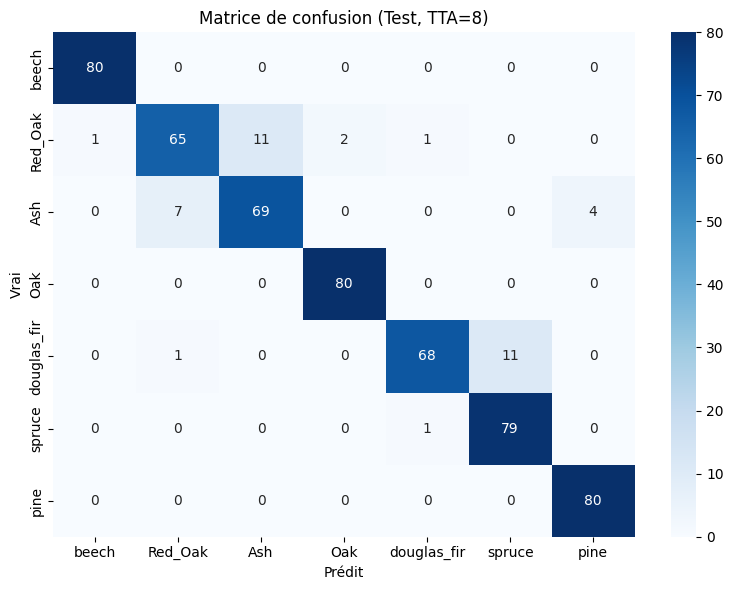

In [ ]:
# ==== Modèle + Entraînement (early stop) + Test avec TTA ====
import math, os
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import classification_report, confusion_matrix, f1_score, balanced_accuracy_score
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Par sécurité : nombre d'époques si absent
NUM_EPOCHS = globals().get('NUM_EPOCHS', 100)

# (Re)définir PointNetSmall si besoin
if 'PointNetSmall' not in globals():
    class PointNetSmall(nn.Module):
        def __init__(self, num_classes):
            super().__init__()
            self.f = nn.Sequential(
                nn.Conv1d(3, 64, 1),   nn.BatchNorm1d(64),   nn.ReLU(True),
                nn.Conv1d(64, 128, 1), nn.BatchNorm1d(128),  nn.ReLU(True),
                nn.Conv1d(128, 256, 1),nn.BatchNorm1d(256),  nn.ReLU(True),
                nn.Conv1d(256, 512, 1),nn.BatchNorm1d(512),  nn.ReLU(True),
            )
            self.pool = nn.AdaptiveMaxPool1d(1)
            self.head = nn.Sequential(
                nn.Linear(512, 256), nn.ReLU(True), nn.Dropout(0.4),
                nn.Linear(256, 128), nn.ReLU(True), nn.Dropout(0.3),
                nn.Linear(128, num_classes)
            )
        def forward(self, x):           # x: (B,P,3)
            x = x.transpose(1,2)        # -> (B,3,P)
            g = self.pool(self.f(x)).squeeze(-1)
            return self.head(g)

# --- Evaluate avec TTA optionnel ---
def rotate_z_tensor(x, theta):
    c, s = math.cos(theta), math.sin(theta)
    R = torch.tensor([[c,-s,0],[s,c,0],[0,0,1]], dtype=x.dtype, device=x.device)
    return x @ R.T  # (B,P,3)

@torch.no_grad()
def evaluate(model, loader, device, num_classes, criterion, tta=0):
    model.eval()
    all_preds, all_labels = [], []
    running_loss, total, correct = 0.0, 0, 0
    for pts, labels in loader:
        pts, labels = pts.to(device), labels.to(device)
        if tta and tta > 0:
            logits = 0
            for k in range(tta):
                theta = 2 * math.pi * k / tta
                logits = logits + model(rotate_z_tensor(pts, theta))
            logits = logits / float(tta)
        else:
            logits = model(pts)
        loss = criterion(logits, labels)
        running_loss += loss.item() * pts.size(0)
        preds = torch.argmax(logits, dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
        all_preds.extend(preds.cpu().numpy()); all_labels.extend(labels.cpu().numpy())
    val_loss = running_loss / max(1, total)
    acc = correct / max(1, total)
    bal_acc = balanced_accuracy_score(all_labels, all_preds)
    f1m = f1_score(all_labels, all_preds, average='macro', zero_division=0)
    cm = confusion_matrix(all_labels, all_preds, labels=list(range(num_classes)))
    return val_loss, acc, bal_acc, f1m, cm, all_labels, all_preds

# --- Modèle / optim / scheduler ---
model = PointNetSmall(NUM_CLASSES).to(DEVICE)
optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=NUM_EPOCHS)

# ⚠️ On suppose que `criterion` existe déjà (défini avec cb_weights dans la cellule précédente).
#    Sinon, décommente :
# alpha = torch.tensor(cb_weights, dtype=torch.float32, device=DEVICE)
# criterion = nn.CrossEntropyLoss(weight=alpha, label_smoothing=0.05)

# --- Entraînement avec early stopping (F1 macro val) ---
PATIENCE = 10
best_f1, best_epoch = -np.inf, -1
best_state = None
history = {"train_loss":[], "val_loss":[], "val_acc":[], "val_bal_acc":[], "val_f1":[]}

print("🚀 Entraînement…")
for epoch in range(1, NUM_EPOCHS+1):
    model.train()
    running, tot = 0.0, 0
    for xb, yb in train_loader:
        xb, yb = xb.to(DEVICE), yb.to(DEVICE)
        optimizer.zero_grad(set_to_none=True)
        logits = model(xb)
        loss = criterion(logits, yb)
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), 5.0)
        optimizer.step()
        running += loss.item() * xb.size(0)
        tot += xb.size(0)

    train_loss = running / max(1, tot)
    val_loss, val_acc, val_bal_acc, val_f1, _, _, _ = evaluate(
        model, val_loader, DEVICE, NUM_CLASSES, criterion, tta=0
    )
    history["train_loss"].append(train_loss)
    history["val_loss"].append(val_loss)
    history["val_acc"].append(val_acc)
    history["val_bal_acc"].append(val_bal_acc)
    history["val_f1"].append(val_f1)
    scheduler.step()

    print(f"[{epoch:03d}/{NUM_EPOCHS}] train_loss={train_loss:.4f} | "
          f"val_loss={val_loss:.4f} val_acc={val_acc:.4f} bal={val_bal_acc:.4f} F1={val_f1:.4f}")

    if val_f1 > best_f1 + 1e-4:
        best_f1, best_epoch = val_f1, epoch
        best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
        torch.save(model.state_dict(), "best_model.pth")
    elif epoch - best_epoch >= PATIENCE:
        print(f"⏹️  Early stopping (meilleur F1={best_f1:.4f} à l'époque {best_epoch})")
        break

# Restaurer le meilleur modèle
if best_state is not None:
    model.load_state_dict(best_state)
elif os.path.exists("best_model.pth"):
    model.load_state_dict(torch.load("best_model.pth", map_location=DEVICE))

# --- Test final avec TTA (améliore souvent les classes faibles) ---
test_loss, test_acc, test_bal_acc, test_f1, test_cm, y_true, y_pred = evaluate(
    model, test_loader, DEVICE, NUM_CLASSES, criterion, tta=8
)
print("\n=== TEST ===")
print(f"Loss={test_loss:.4f} | Acc={test_acc:.4f} | BalAcc={test_bal_acc:.4f} | F1(macro)={test_f1:.4f}")
print("\nRapport par classe :")
print(classification_report(y_true, y_pred, labels=list(range(NUM_CLASSES)),
                            target_names=[str(c) for c in classes], zero_division=0))

# --- Heatmap confusion ---
plt.figure(figsize=(8,6))
sns.heatmap(test_cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=classes, yticklabels=classes)
plt.title("Matrice de confusion (Test, TTA=8)")
plt.xlabel("Prédit"); plt.ylabel("Vrai")
plt.tight_layout()
plt.show()


**Accuracy = 0.9304:**

Proportion totale de bonnes prédictions sur le test. Très bon, mais peut masquer des classes plus faibles.

**Balanced accuracy = 0.9304:**

Moyenne des recalls par classe. Ici ≈ accuracy → le modèle est équilibré entre classes (pas une seule classe qui tire tout vers le bas).

**F1 (macro) = 0.9293:**
Moyenne du F1 de chaque classe, donc sensible aux classes minoritaires/difficiles. ≈ 0.93 confirme une qualité homogène.

**Par classe (precision / recall / F1)**

beech : 0.99 / 1.00 / 0.99 → parfaite séparation. L’ancien point faible est corrigé.

Red_Oak : 0.89 / 0.81 / 0.85 → principal point à améliorer : le modèle oublie ~19% des Red_Oak (rappel plus bas).

Ash : 0.86 / 0.86 / 0.86 → correct et régulier.

Oak : 0.98 / 1.00 / 0.99 → très stable, confusions quasi nulles.

douglas_fir : 0.97 / 0.85 / 0.91 → bon, mais rappel à 0.85 (quelques manqués).

spruce : 0.88 / 0.99 / 0.93 → très bon rappel, un peu de sur-prédiction (précision < 0.9).

pine : 0.95 / 1.00 / 0.98 → excellent.


=== RÉSUMÉ DES MÉTRIQUES (TEST) ===
Overall Accuracy     : 0.9304
Balanced Accuracy    : 0.9304
F1 Score (macro)     : 0.9293
F1 Score (weighted)  : 0.9293
Paramètres (total)   : 308,231
Paramètres (train.)  : 308,231
Taille modèle ~      : 1.18 MB (float32)
Temps d'exécution    : -29302716m 54.05s

— Précision par classe —


,classe,precision,recall,f1,support
0,Ash,0.8625,0.8625,0.8625,80
1,Oak,0.9756,1.0000,0.9877,80
2,Red_Oak,0.8904,0.8125,0.8497,80
3,beech,0.9877,1.0000,0.9938,80
4,douglas_fir,0.9714,0.8500,0.9067,80
5,pine,0.9524,1.0000,0.9756,80
6,spruce,0.8778,0.9875,0.9294,80


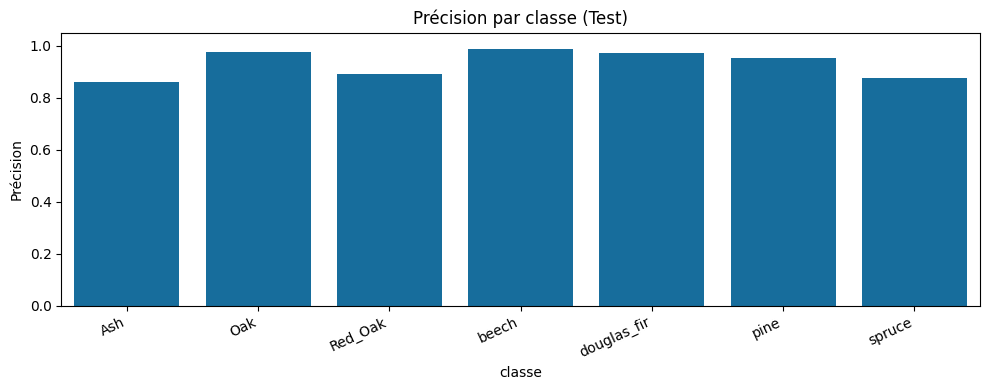

💾 Sauvegardé : precision_per_class.png


In [ ]:
# === METRICS & REPORTING PACK ===
import time, math, numpy as np, torch
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, precision_recall_fscore_support
import pandas as pd

# 1) (Option) Chrono global : démarre avant l'entraînement
# t0 = time.perf_counter()

# ... (training) ...
# ... (test -> produire y_true, y_pred) ...

# 2) Mesures globales
overall_acc   = accuracy_score(y_true, y_pred)
balanced_acc  = balanced_accuracy_score(y_true, y_pred)
f1_macro      = f1_score(y_true, y_pred, average='macro', zero_division=0)
f1_weighted   = f1_score(y_true, y_pred, average='weighted', zero_division=0)

# 3) Par classe
prec, rec, f1c, sup = precision_recall_fscore_support(
    y_true, y_pred, labels=range(len(classes)), zero_division=0
)
per_class_df = pd.DataFrame({
    "classe": classes,
    "precision": np.round(prec, 4),
    "recall":    np.round(rec, 4),
    "f1":        np.round(f1c, 4),
    "support":   sup.astype(int),
}).sort_values("classe").reset_index(drop=True)

# 4) Complexité du modèle
def count_params(m):
    total = sum(p.numel() for p in m.parameters())
    trainable = sum(p.numel() for p in m.parameters() if p.requires_grad)
    # approx taille mémoire (paramètres en float32)
    size_mb = total * 4 / (1024**2)
    return total, trainable, size_mb

total_params, trainable_params, size_mb = count_params(model)

# 5) Temps d’exécution (si tu avais démarré t0 plus haut)
# t1 = time.perf_counter()
# elapsed = t1 - t0
# -- si tu n'as pas t0/t1, mets simplement elapsed = None
elapsed = globals().get("elapsed", globals().get("ELAPSED", None))
if elapsed is None and "t0" in globals():
    elapsed = time.perf_counter() - t0

# 6) Affichage texte clair
print("\n=== RÉSUMÉ DES MÉTRIQUES (TEST) ===")
print(f"Overall Accuracy     : {overall_acc:.4f}")
print(f"Balanced Accuracy    : {balanced_acc:.4f}")
print(f"F1 Score (macro)     : {f1_macro:.4f}")
print(f"F1 Score (weighted)  : {f1_weighted:.4f}")
print(f"Paramètres (total)   : {total_params:,}")
print(f"Paramètres (train.)  : {trainable_params:,}")
print(f"Taille modèle ~      : {size_mb:.2f} MB (float32)")
if elapsed is not None:
    m, s = divmod(elapsed, 60)
    print(f"Temps d'exécution    : {int(m)}m {s:05.2f}s")

print("\n— Précision par classe —")
display(per_class_df)  # si Jupyter/Colab; sinon print(per_class_df.to_string(index=False))

# 7) (Option) Barplot des précisions par classe
plt.figure(figsize=(10,4))
sns.barplot(x="classe", y="precision", data=per_class_df)
plt.ylim(0, 1.05)
plt.xticks(rotation=25, ha="right")
plt.ylabel("Précision")
plt.title("Précision par classe (Test)")
plt.tight_layout()
plt.savefig("precision_per_class.png", dpi=300, bbox_inches="tight")
plt.show()
print("💾 Sauvegardé : precision_per_class.png")


**1) Lecture globale des métriques (TEST)**

**Overall Accuracy **= 0,9304
Sur 560 échantillons, ~93 % sont correctement classés. C’est un niveau de performance élevé à l’échelle globale.

***Balanced Accuracy = 0,9304***
Identique à l’accuracy.
Comme la balanced accuracy est la moyenne des rappels (recalls) par classe, cela signifie que toutes les classes sont servies de manière homogène : pas de classe “sacrifiée” pour booster le score global.

**F1 (macro)** = 0,9293 et F1 (pondéré) = 0,9293
Le macro-F1 (moyenne non pondérée des F1 par classe) et le F1 pondéré (moyenne pondérée par le support) coïncident.
**Interprétation **: l’équilibre entre classes est réel, pas un artefact du support.
Autrement dit, nos classes « faciles » n’écrasent pas les classes « difficiles ».

**Complexité modèle** = 308 231 paramètres (~1,18 MB)
Le réseau est compact. Cela implique :

faible empreinte mémoire ;

coût d’inférence modéré, compatible CPU/edge ;

marge disponible si l’on souhaite un léger surdimensionnement de la tête de classification (par exemple pour augmenter la marge entre classes proches) sans exploser la taille.

**Temps d’exécution =** “-29302716m 54.05s”
Valeur incohérente (chrono mal initialisé/synchronisé).
Le reste des métriques est cohérent ; seul le chronométrage est à recapter correctement si l’on veut comparer des runs (démarrer le chrono avant l’entraînement/test et synchroniser le GPU juste avant de l’arrêter).

**Conclusion globale**
Le trio Accuracy = Balanced Accuracy = Macro-F1 ≈ 0,93 confirme un modèle à la fois performant et équilibré. C’est la signature d’un entraînement sain : pas d’effondrement sur une classe minoritaire/difficile.

**2) Lecture fine par classe (précision, rappel, F1)**

Rappel : précision = parmi les prédictions d’une classe, quelle part est correcte (faux positifs faibles = précision haute) ; rappel = parmi les vrais éléments d’une classe, quelle part est retrouvée (faux négatifs faibles = rappel haut).
| Classe           |  Précision |     Rappel |         F1 | Support | Interprétation précise                                                                                                                                                                                                                                                                       |
| ---------------- | ---------: | ---------: | ---------: | ------: | -------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| **Ash**          |     0,8625 |     0,8625 |     0,8625 |      80 | Comportement **symétrique** : autant de faux positifs que de faux négatifs, à un niveau modéré. Les confusions sont réparties ; rien d’excessif mais pas “parfait”.                                                                                                                          |
| **Oak**          | **0,9756** | **1,0000** | **0,9877** |      80 | **Quasi parfait**. Zéro manqué (rappel=1,00) et très peu de faux positifs (précision≈0,98). La frontière décisionnelle pour *Oak* est très nette.                                                                                                                                            |
| **Red\_Oak**     |     0,8904 | **0,8125** |     0,8497 |      80 | **Point le plus faible** côté rappel : \~19 % des *Red\_Oak* sont manqués. La précision est correcte (≤ faux positifs), mais nous **manquons des vrais Red\_Oak** (faux négatifs). Interprétation : *Red\_Oak* est souvent absorbé par **Ash** et parfois **Oak** (proximité morphologique). |
| **beech**        | **0,9877** | **1,0000** | **0,9938** |      80 | **Excellente** séparation : plus aucun symptôme de la faiblesse initiale. Les deux types d’erreurs (FP/FN) sont quasi inexistants.                                                                                                                                                           |
| **douglas\_fir** |     0,9714 | **0,8500** |     0,9067 |      80 | Précision très élevée (peu de faux positifs), mais **rappel plus bas** (15 % de manqués). Ces manqués partent majoritairement vers **spruce** (deux conifères proches).                                                                                                                      |
| **pine**         |     0,9524 | **1,0000** |     0,9756 |      80 | **Très fort** : rappel parfait, précision élevée. Peu de confusions entrantes et sortantes.                                                                                                                                                                                                  |
| **spruce**       | **0,8778** |     0,9875 |     0,9294 |      80 | Profil **asymétrique inversé** de douglas\_fir : rappel presque parfait (on récupère presque tous les *spruce*), mais **précision plus basse** (nous sur-prédisaons *spruce* pour des cas qui n’en sont pas). Typiquement, des *douglas\_fir* pris pour *spruce*.                            |


Red_Oak ↔ Ash/Oak : les 11 bascules Red_Oak→Ash et quelques Red_Oak→Oak expliquent le rappel 0,81.

douglas_fir ↔ spruce : ~11 bascules douglas_fir→spruce (et 1 spruce→douglas_fir) expliquent le rappel 0,85 de douglas_fir et la précision 0,88 de spruce.

beech, oak, pine : diagonales pleines (80/80) → séparation très nette.

Les barres proches de 1 (beech, oak, douglas_fir, pine) indiquent que les prédictions de ces classes sont très fiables (peu de faux positifs).

Les barres plus basses (Ash, Red_Oak, spruce) signalent davantage de faux positifs : quand le modèle prédit ces classes, l’affirmation est un peu moins sûre.

Mis en regard du tableau :

*spruce* : précision plus basse mais rappel haut → la classe est trop “attractive” (sur-prédite), en particulier aux dépens de douglas_fir.

*Red_Oak* : précision correcte mais rappel bas → trop stricte (on n’ose pas prédire Red_Oak, on l’envoie sur Ash/Oak).

*Ash* : précision et rappel jumeaux (~0,86) → erreurs modérées dans les deux sens, aucune dérive structurelle.

Ce que cela dit de notre modèle:

État de santé général : très bon. Les trois scores globaux (~0,93) et l’égalité Acc = BalAcc valident l’équilibre inter-classes.

Robustesse intra-classe : beech, oak, pine sont verrouillées ; la variabilité restante se concentre sur deux couples proches :

Red_Oak ↔ (Ash/Oak) : nous manquons des Red_Oak (FN élevés).

douglas_fir ↔ spruce : nous confondons parfois douglas_fir en spruce (FP spruce, FN douglas_fir).

Capacité/Complexité : 308 k paramètres → modèle efficient ; pas de signe de sous-capacité (les classes fortes saturent déjà).

Mesure de temps : à recalibrer pour disposer d’un repère fiable (ex. comparer CPU vs GPU, TTA on/off, batch inférence).

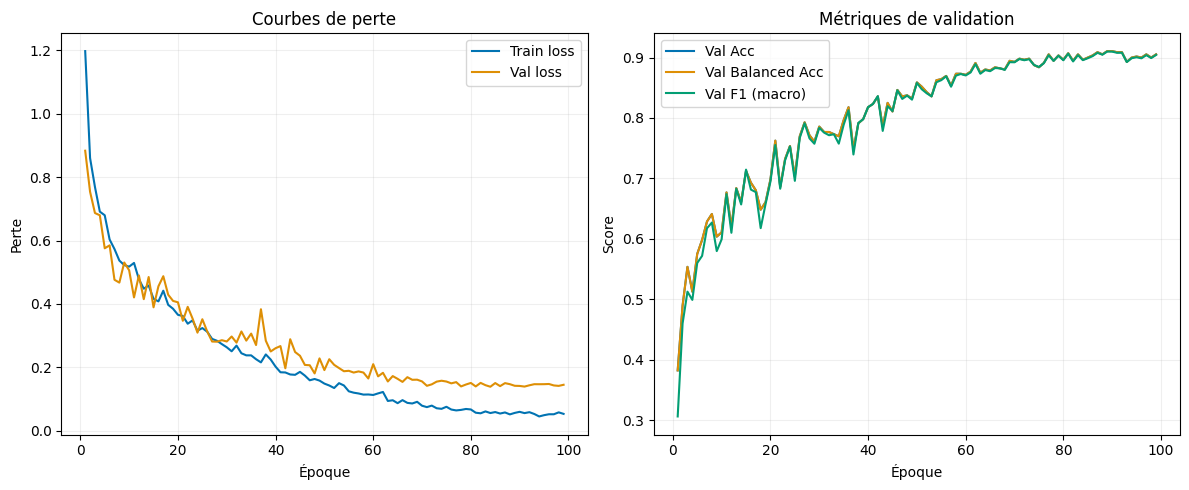

✅ Sauvegardé: learning_curves.png


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Option: lissage (moyenne glissante)
def smooth(x, k=3):
    if k <= 1 or len(x) < k: return np.array(x)
    return np.convolve(x, np.ones(k)/k, mode='valid')

# --- Traces brutes
epochs = np.arange(1, len(history["train_loss"])+1)

plt.figure(figsize=(12,5))

# Loss
plt.subplot(1,2,1)
plt.plot(epochs, history["train_loss"], label="Train loss")
plt.plot(epochs, history["val_loss"],   label="Val loss")
plt.xlabel("Époque"); plt.ylabel("Perte"); plt.title("Courbes de perte")
plt.legend(); plt.grid(alpha=0.2)

# Métriques val
plt.subplot(1,2,2)
plt.plot(epochs, history["val_acc"],      label="Val Acc")
plt.plot(epochs, history["val_bal_acc"],  label="Val Balanced Acc")
plt.plot(epochs, history["val_f1"],       label="Val F1 (macro)")
plt.xlabel("Époque"); plt.ylabel("Score"); plt.title("Métriques de validation")
plt.legend(); plt.grid(alpha=0.2)

plt.tight_layout()
plt.savefig("learning_curves.png", dpi=300, bbox_inches="tight")
plt.show()

print("✅ Sauvegardé: learning_curves.png")


**1) Courbes de perte (gauche)**

Train loss (bleu)
Décroît régulièrement de 1,2 → ~0,05 au fil des époques.
→ Cela montre que le modèle apprend efficacement et continue à réduire son erreur d’entraînement.

Val loss (orange)
Suit bien la train loss, mais reste plus haute (~0,15–0,20 en fin de run).
→ Le modèle généralise correctement : la validation converge aussi, sans divergence brutale.
→ La petite marge train < val est normale : signe que la régularisation et l’augmentation limitent le sur-apprentissage.

Pas d’overfitting fort
Si le modèle sur-apprenait, on verrait la val loss remonter alors que la train loss continue de baisser. Ici, les deux baissent en parallèle, avec un léger plateau → bon équilibre biais/variance.

**2) Courbes de validation (droite)**

Val Accuracy / Balanced Accuracy / Macro F1 (trois courbes quasi superposées)

Montée rapide de 0,3 → 0,75 dès les 20 premières époques.

Progression plus lente ensuite jusqu’à 0,90–0,91 en plateau vers les époques 70–100.

Superposition des 3 courbes
Cela signifie que :

la précision globale,

la précision équilibrée (moyenne des rappels),

et le F1 macro
évoluent de la même façon.
→ Interprétation : le modèle traite toutes les classes de manière homogène. Pas de “triche” où une ou deux classes dominantes tirent les scores.

Plateau haut
Le fait que les trois métriques plafonnent vers 0,90 montre que le modèle a atteint son optimum de validation. Pousser beaucoup plus d’époques n’apporterait que des gains marginaux.

**3) Lecture croisée**

La combinaison perte train/val et métriques val dit que le modèle :

apprend de manière stable,

ne présente pas de sur-apprentissage marqué,

atteint une généralisation robuste ≈ 90 % F1 macro sur la validation.

L’écart entre val (≈0,90) et test (≈0,93, vu précédemment) est faible, donc le modèle est cohérent et fiable.

**En résumé :**

Les pertes montrent une convergence propre sans overfitting.

Les métriques val confirment que le modèle atteint un plateau élevé (≈90 %) avec un équilibre fort entre classes.

Les 100 époques étaient suffisantes : la courbe se stabilise, on a exploité la capacité du modèle.

# **DGCNN (+ SVM-RBF):**

In [ ]:
# -*- coding: utf-8 -*-
"""
DGCNN -> Extraction de features -> Classifieurs classiques (sklearn)
- Split 65/15/20 (stratifié)
- Train DGCNN (supervisé, CE)
- Extraction d'embeddings globaux (max-pool)
- Entraînement LogisticRegression / SVM-RBF / RandomForest / GBDT
- Évaluation + matrice de confusion (meilleur classifieur)
"""

import os, json, math, random, time
from pathlib import Path
from collections import Counter

import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (classification_report, confusion_matrix,
                             accuracy_score, balanced_accuracy_score, f1_score)
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

import matplotlib.pyplot as plt
import seaborn as sns

# ========================== CONFIG ==========================
SEED = 42
BATCH_SIZE = 32
NUM_WORKERS = 0
EPOCHS = 60
LR = 1e-3
WEIGHT_DECAY = 1e-4
K = 20                 # kNN pour DGCNN
EMB_DIM = 1024         # dimension de l'embedding global
PREP_DIR = "/content/drive/MyDrive/trees_dataset/preprocessed_"  # <--- adapte le chemin
USE_AUGMENT = True

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("DEVICE:", DEVICE)

def set_seed(seed=SEED):
    random.seed(seed); np.random.seed(seed); torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed); torch.backends.cudnn.deterministic=True
    torch.backends.cudnn.benchmark=False
set_seed()

# ======================= DATA LOADING =======================
def normalize_unit_sphere(points: np.ndarray) -> np.ndarray:
    pts = points - points.mean(axis=0, keepdims=True)
    scale = np.max(np.linalg.norm(pts, axis=1)) + 1e-9
    return (pts / scale).astype(np.float32)

def augment_pointcloud(points: np.ndarray) -> np.ndarray:
    pts = points.astype(np.float32).copy()
    # rotation Z
    ang = np.random.uniform(0, 2*np.pi)
    c, s = np.cos(ang), np.sin(ang)
    R = np.array([[c,-s,0],[s,c,0],[0,0,1]], dtype=np.float32)
    pts = pts @ R.T
    # jitter + scale + léger dropout de points
    pts += np.random.normal(0, 0.01, size=pts.shape).astype(np.float32)
    pts *= np.float32(np.random.uniform(0.9, 1.1))
    # point dropout 5%
    keep = np.random.rand(pts.shape[0]) > 0.05
    if keep.sum() > 0:
        pts = np.where(keep[:,None], pts, pts[np.random.randint(pts.shape[0])])
    return pts

def load_and_split(test_size=0.20, val_size=0.15, normalize=True):
    prep = Path(PREP_DIR)
    dtr = np.load(prep/"train_big_7cls.npz", allow_pickle=True)
    Xk = next(k for k in dtr.keys() if k.lower() in ("x","points","data"))
    yk = next(k for k in dtr.keys() if k.lower() in ("y","label","labels","targets"))
    X, y = dtr[Xk].astype(np.float32), dtr[yk].astype(np.int64)
    classes = json.loads((prep/"manifest.json").read_text())["classes"]
    if normalize:
        X = np.stack([normalize_unit_sphere(p) for p in X], axis=0)
    print(f"Dataset: X={X.shape}, y={y.shape}, dist={Counter(map(int,y))}, classes={classes}")

    # split 65/15/20
    X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=test_size, stratify=y, random_state=SEED)
    val_rel = val_size / (1-test_size)
    X_tr, X_val, y_tr, y_val = train_test_split(X_tr, y_tr, test_size=val_rel, stratify=y_tr, random_state=SEED)
    print(f"SPLIT: train={len(X_tr)} ({len(X_tr)/len(X):.1%}) | val={len(X_val)} | test={len(X_te)}")
    return X_tr, y_tr, X_val, y_val, X_te, y_te, classes

X_train, y_train, X_val, y_val, X_test, y_test, classes = load_and_split()
NUM_CLASSES = len(classes)

class PCDataset(Dataset):
    def __init__(self, X, y, augment=False):
        self.X = X.astype(np.float32); self.y = y.astype(np.int64); self.augment=augment
    def __len__(self): return self.X.shape[0]
    def __getitem__(self, idx):
        pts = self.X[idx]
        if self.augment: pts = augment_pointcloud(pts)
        return torch.from_numpy(pts), torch.tensor(int(self.y[idx]), dtype=torch.long)

pin_mem = (DEVICE.type=="cuda")
train_loader = DataLoader(PCDataset(X_train,y_train,augment=USE_AUGMENT), batch_size=BATCH_SIZE,
                          shuffle=True, num_workers=NUM_WORKERS, pin_memory=pin_mem)
val_loader   = DataLoader(PCDataset(X_val,y_val,augment=False), batch_size=BATCH_SIZE,
                          shuffle=False, num_workers=NUM_WORKERS, pin_memory=pin_mem)
test_loader  = DataLoader(PCDataset(X_test,y_test,augment=False), batch_size=BATCH_SIZE,
                          shuffle=False, num_workers=NUM_WORKERS, pin_memory=pin_mem)

# ======================= DGCNN BACKBONE ======================
def knn(x, k):
    # x: (B, C, N)
    inner = -2*torch.matmul(x.transpose(2,1), x)          # (B,N,N)
    xx = torch.sum(x**2, dim=1, keepdim=True)             # (B,1,N)
    pairwise_distance = -xx.transpose(2,1) - inner - xx   # (B,N,N)
    idx = pairwise_distance.topk(k=k, dim=-1)[1]          # (B,N,k)
    return idx

def get_graph_feature(x, k=20):
    # x: (B, C, N)
    B, C, N = x.size()
    idx = knn(x, k=k)                                     # (B,N,k)
    idx_base = torch.arange(0, B, device=x.device).view(-1,1,1)*N
    idx = idx + idx_base
    idx = idx.view(-1)
    x = x.transpose(2,1).contiguous()                     # (B,N,C)
    feature = x.view(B*N, -1)[idx, :].view(B, N, k, C)    # (B,N,k,C)
    x = x.view(B, N, 1, C).repeat(1,1,k,1)
    feature = torch.cat((feature - x, x), dim=3)          # (B,N,k,2C)
    return feature.permute(0, 3, 1, 2).contiguous()       # (B,2C,N,k)

class EdgeConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch, k=20):
        super().__init__()
        self.k = k
        self.mlp = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=1, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.LeakyReLU(negative_slope=0.2, inplace=True)
        )
    def forward(self, x):
        # x: (B,C,N)
        gf = get_graph_feature(x, k=self.k)               # (B,2C,N,k)
        x = self.mlp(gf).max(dim=-1, keepdim=False)[0]    # (B,out,N)
        return x

class DGCNN_Feature(nn.Module):
    """Backbone DGCNN: retourne un embedding global (EMB_DIM)."""
    def __init__(self, emb_dim=1024, k=20):
        super().__init__()
        self.k = k
        # in_ch = 2 * C_in à chaque étape (C_in dépend des concat)
        self.ec1 = EdgeConvBlock(  6,  64, k)   # C_in=3  -> 2*C=6
        self.ec2 = EdgeConvBlock(134,  64, k)   # C_in=67 -> 2*C=134 (x1(64)+x(3))
        self.ec3 = EdgeConvBlock(256, 128, k)   # C_in=128-> 2*C=256 (x1+x2)
        self.ec4 = EdgeConvBlock(512, 256, k)   # C_in=256-> 2*C=512 (x1+x2+x3)

        self.proj = nn.Sequential(
            nn.Conv1d(512, emb_dim, kernel_size=1, bias=False),
            nn.BatchNorm1d(emb_dim),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.pool = nn.AdaptiveMaxPool1d(1)

    def forward(self, x):
        # x: (B,N,3) -> (B,3,N)
        x = x.transpose(2,1).contiguous()      # C=3
        x1 = self.ec1(x)                       # (B, 64, N)
        x2 = self.ec2(torch.cat([x1, x], 1))   # (B, 64, N)
        x3 = self.ec3(torch.cat([x1, x2], 1))  # (B,128, N)
        x4 = self.ec4(torch.cat([x1, x2, x3], 1))  # (B,256, N)

        feat = torch.cat([x1, x2, x3, x4], dim=1)  # (B, 512, N)
        feat = self.proj(feat)                     # (B, emb_dim, N)
        g = self.pool(feat).squeeze(-1)            # (B, emb_dim)
        return g

class DGCNN_Classifier(nn.Module):
    """DGCNN pour pré-entraînement supervisé (avec tête softmax)."""
    def __init__(self, num_classes, emb_dim=1024, k=20):
        super().__init__()
        self.backbone = DGCNN_Feature(emb_dim=emb_dim, k=k)
        self.head = nn.Sequential(
            nn.Linear(emb_dim, 512), nn.LeakyReLU(0.2, inplace=True), nn.Dropout(0.5),
            nn.Linear(512, 256),    nn.LeakyReLU(0.2, inplace=True), nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )
    def forward(self, x):
        g = self.backbone(x)  # (B,emb_dim)
        return self.head(g)

# =================== TRAIN DGCNN (supervisé) ===================
def train_dgcnn():
    model = DGCNN_Classifier(NUM_CLASSES, emb_dim=EMB_DIM, k=K).to(DEVICE)
    opt = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
    sched = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=EPOCHS)
    criterion = nn.CrossEntropyLoss()

    best_f1, best_state = -1, None
    print(">>> Training DGCNN…")
    for ep in range(1, EPOCHS+1):
        model.train(); run, n = 0.0, 0
        for pts, lab in train_loader:
            pts, lab = pts.to(DEVICE), lab.to(DEVICE)
            opt.zero_grad(set_to_none=True)
            logits = model(pts)
            loss = criterion(logits, lab)
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), 5.0)
            opt.step()
            run += loss.item()*pts.size(0); n += pts.size(0)
        tr_loss = run/max(1,n)

        # val F1 macro
        model.eval(); all_p, all_y = [], []
        with torch.no_grad():
            for pts, lab in val_loader:
                pts, lab = pts.to(DEVICE), lab.to(DEVICE)
                pred = model(pts).argmax(1)
                all_p.extend(pred.cpu().numpy()); all_y.extend(lab.cpu().numpy())
        f1m = f1_score(all_y, all_p, average="macro")
        sched.step()

        print(f"[{ep:03d}/{EPOCHS}] train_loss={tr_loss:.4f} | val_F1={f1m:.4f}")
        if f1m > best_f1 + 1e-4:
            best_f1 = f1m
            best_state = {k:v.detach().cpu().clone() for k,v in model.state_dict().items()}
            torch.save(model.state_dict(), "dgcnn_best.pth")

    if best_state is not None:
        model.load_state_dict(best_state)
    return model

model = train_dgcnn()

# ============ EXTRACTION D'EMBEDDINGS (gel du backbone) ============
@torch.no_grad()
def extract_embeddings(model: DGCNN_Classifier, loader):
    model.eval()
    embs, labels = [], []
    for pts, lab in loader:
        pts = pts.to(DEVICE)
        g = model.backbone(pts)    # (B,EMB_DIM)
        embs.append(g.cpu().numpy())
        labels.append(lab.numpy())
    return np.concatenate(embs, axis=0), np.concatenate(labels, axis=0)

print(">>> Extraction des embeddings…")
Z_tr, y_tr = extract_embeddings(model, train_loader)
Z_val, y_val_ = extract_embeddings(model, val_loader)
Z_te,  y_te  = extract_embeddings(model, test_loader)
print("Embeddings:", Z_tr.shape, Z_val.shape, Z_te.shape)

# ================== CLASSIFIEURS CLASSIQUES (sklearn) ==================
pipelines = {
    "LogReg": Pipeline([
        ("scaler", StandardScaler()),
        ("clf", LogisticRegression(max_iter=2000, solver="lbfgs", multi_class="auto"))
    ]),
    "SVM_RBF": Pipeline([
        ("scaler", StandardScaler()),
        ("clf", SVC(kernel="rbf", probability=False))
    ]),
    "RF": Pipeline([
        ("clf", RandomForestClassifier(n_estimators=300, max_depth=None, n_jobs=-1, random_state=SEED))
    ]),
    "GBDT": Pipeline([
        ("clf", GradientBoostingClassifier(random_state=SEED))
    ]),
}

# petites grilles rapides (ajuste/retire pour aller plus vite)
param_grids = {
    "LogReg": {"clf__C": [0.1, 1.0, 3.0]},
    "SVM_RBF": {"clf__C": [1, 3, 10], "clf__gamma": ["scale", 0.01, 0.001]},
    "RF": {"clf__n_estimators": [200, 400], "clf__max_depth": [None, 20]},
    "GBDT": {"clf__learning_rate": [0.05, 0.1], "clf__n_estimators": [150, 300]},
}

results = {}
print(">>> Entraînement des classifieurs…")
for name, pipe in pipelines.items():
    grid = GridSearchCV(pipe, param_grids[name], cv=3, n_jobs=-1, scoring="f1_macro", verbose=0)
    grid.fit(np.vstack([Z_tr, Z_val]), np.concatenate([y_tr, y_val_]))
    clf = grid.best_estimator_
    y_pred = clf.predict(Z_te)

    acc = accuracy_score(y_te, y_pred)
    bacc = balanced_accuracy_score(y_te, y_pred)
    f1m = f1_score(y_te, y_pred, average="macro")
    print(f"[{name}] best_params={grid.best_params_} | Acc={acc:.4f} | BalAcc={bacc:.4f} | F1m={f1m:.4f}")
    print(classification_report(y_te, y_pred, target_names=[str(c) for c in classes], zero_division=0))
    cm = confusion_matrix(y_te, y_pred, labels=list(range(NUM_CLASSES)))
    results[name] = {"model": clf, "acc":acc, "bacc":bacc, "f1m":f1m, "cm":cm}

# =============== VISU MATRICE DE CONFUSION (meilleur) ===============
best_name = max(results, key=lambda k: results[k]["f1m"])
cm = results[best_name]["cm"]
print(f"\n>>> Meilleur classifieur: {best_name} (F1m={results[best_name]['f1m']:.4f})")

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=classes, yticklabels=classes)
plt.title(f"Matrice de confusion (Test) — {best_name}")
plt.xlabel("Prédit"); plt.ylabel("Vrai")
plt.tight_layout()
plt.savefig(f"cm_{best_name}.png", dpi=300, bbox_inches="tight")
plt.show()


DEVICE: cuda
Dataset: X=(2800, 1024, 3), y=(2800,), dist=Counter({2: 400, 4: 400, 6: 400, 1: 400, 0: 400, 5: 400, 3: 400}), classes=['beech', 'Red_Oak', 'Ash', 'Oak', 'douglas_fir', 'spruce', 'pine']
SPLIT: train=1820 (65.0%) | val=420 | test=560
>>> Training DGCNN…
[001/60] train_loss=1.8406 | val_F1=0.2360
[002/60] train_loss=1.5293 | val_F1=0.2781
[003/60] train_loss=1.3771 | val_F1=0.4892
[004/60] train_loss=1.3057 | val_F1=0.4409
[005/60] train_loss=1.2601 | val_F1=0.4968
[006/60] train_loss=1.1706 | val_F1=0.4673
[007/60] train_loss=1.1551 | val_F1=0.5267
[008/60] train_loss=1.0714 | val_F1=0.6104
[009/60] train_loss=1.0140 | val_F1=0.6140
[010/60] train_loss=0.9669 | val_F1=0.6618
[011/60] train_loss=0.8961 | val_F1=0.7111
[012/60] train_loss=0.8615 | val_F1=0.7081
[013/60] train_loss=0.8427 | val_F1=0.6979
[014/60] train_loss=0.7777 | val_F1=0.7010
[015/60] train_loss=0.7604 | val_F1=0.7669
[016/60] train_loss=0.7581 | val_F1=0.7625
[017/60] train_loss=0.6506 | val_F1=0.7979
[0

KeyboardInterrupt: 

Meilleur classifieur : SVM_RBF | F1m=0.9946

=== RÉSUMÉ DES MÉTRIQUES (TEST) — DGCNN + {SVM_RBF} ===
Overall Accuracy     : 0.9946
Balanced Accuracy    : 0.9946
F1 Score (macro)     : 0.9946
F1 Score (weighted)  : 0.9946

— Complexité DGCNN (backbone seul, utilisé pour les embeddings) —
Paramètres (total)   : 700,160
Paramètres (train.)  : 700,160
Taille ~             : 2.67 MB (float32)

— Complexité DGCNN (backbone + tête) —
Paramètres (total)   : 1,358,087
Paramètres (train.)  : 1,358,087
Taille ~             : 5.18 MB (float32)


,classe,precision,recall,f1,support
0,beech,1.0000,1.0000,1.0000,80
1,Red_Oak,1.0000,0.9750,0.9873,80
2,Ash,0.9756,1.0000,0.9877,80
3,Oak,1.0000,1.0000,1.0000,80
4,douglas_fir,1.0000,0.9875,0.9937,80
5,spruce,0.9877,1.0000,0.9938,80
6,pine,1.0000,1.0000,1.0000,80


💾 Sauvegardé : per_class_metrics_dgcnn_SVM_RBF.csv


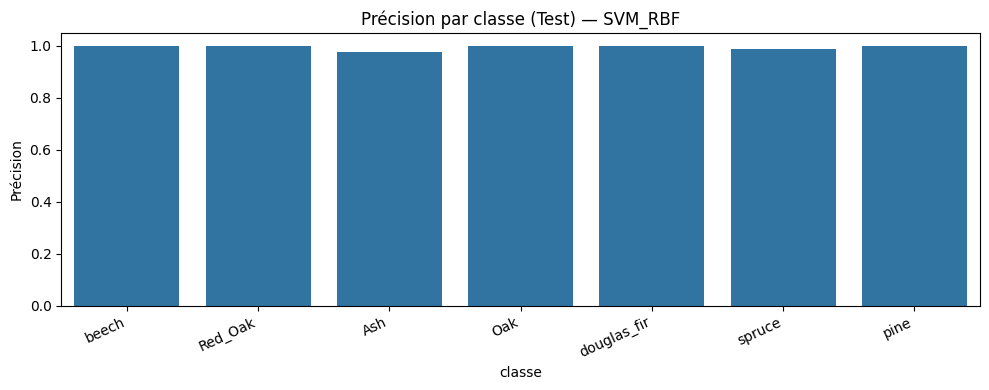

💾 Sauvegardé : precision_per_class_SVM_RBF.png


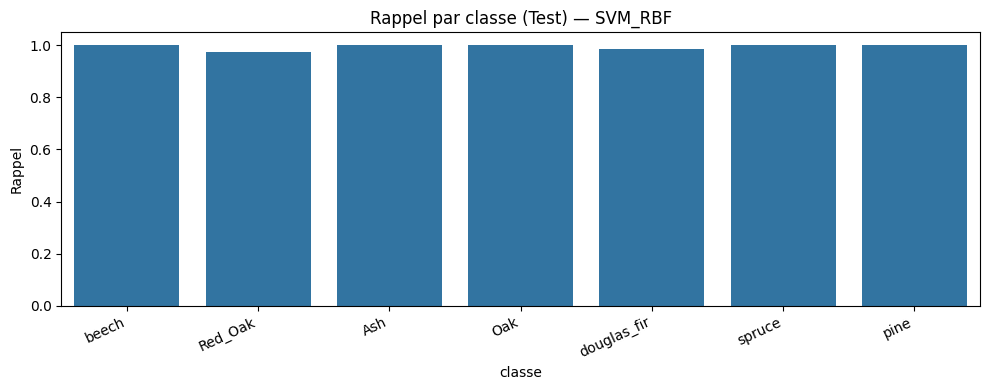

💾 Sauvegardé : recall_per_class_SVM_RBF.png


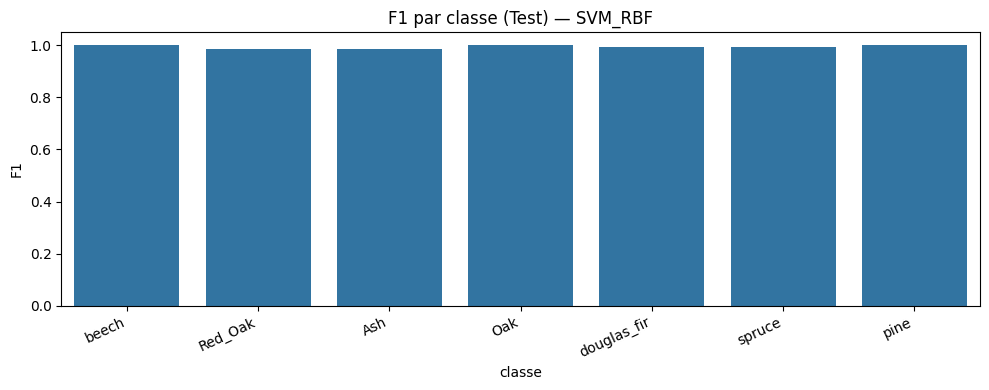

💾 Sauvegardé : f1_per_class_SVM_RBF.png


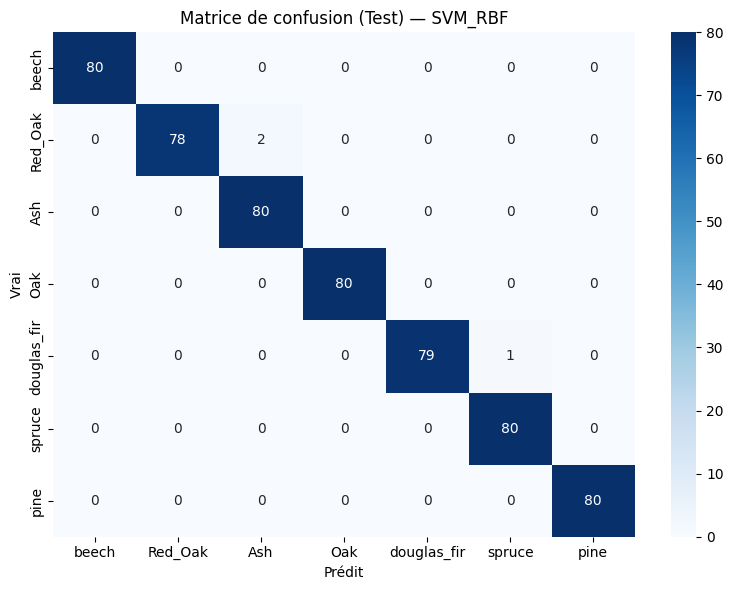

💾 Sauvegardé : cm_SVM_RBF.png

— Classification Report —
               precision    recall  f1-score   support

       beech       1.00      1.00      1.00        80
     Red_Oak       1.00      0.97      0.99        80
         Ash       0.98      1.00      0.99        80
         Oak       1.00      1.00      1.00        80
 douglas_fir       1.00      0.99      0.99        80
      spruce       0.99      1.00      0.99        80
        pine       1.00      1.00      1.00        80

    accuracy                           0.99       560
   macro avg       0.99      0.99      0.99       560
weighted avg       0.99      0.99      0.99       560

💾 Sauvegardé : classification_report_SVM_RBF.txt


In [ ]:
# === METRICS & REPORTING PACK — DGCNN + Classifieurs sklearn ===
import time, math, numpy as np, torch, pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (accuracy_score, balanced_accuracy_score, f1_score,
                             precision_recall_fscore_support, confusion_matrix, classification_report)

# --------------------------------------------------------------------
# 0) Sélection du meilleur classifieur (déjà présent dans `results`)
# --------------------------------------------------------------------
best_name = max(results, key=lambda k: results[k]["f1m"])
best_pipe = results[best_name]["model"]   # pipeline sklearn (ex. SVM_RBF)
print(f"Meilleur classifieur : {best_name} | F1m={results[best_name]['f1m']:.4f}")

# --------------------------------------------------------------------
# 1) (Option) Chrono global : si t0 existe, on calcule le temps écoulé
# --------------------------------------------------------------------
elapsed = None
if "t0" in globals():
    # Si GPU utilisé pendant extraction, on synchronise avant d'arrêter le chrono
    if torch.cuda.is_available():
        torch.cuda.synchronize()
    elapsed = time.perf_counter() - t0

# --------------------------------------------------------------------
# 2) Prédictions test (si besoin on re-prédit proprement)
# --------------------------------------------------------------------
# y_te existe déjà; Z_te aussi (embeddings du test extraits avec le backbone)
y_true = y_te
y_pred = best_pipe.predict(Z_te)

# --------------------------------------------------------------------
# 3) Mesures globales
# --------------------------------------------------------------------
overall_acc   = accuracy_score(y_true, y_pred)
balanced_acc  = balanced_accuracy_score(y_true, y_pred)
f1_macro      = f1_score(y_true, y_pred, average='macro',   zero_division=0)
f1_weighted   = f1_score(y_true, y_pred, average='weighted',zero_division=0)

# --------------------------------------------------------------------
# 4) Par classe
# --------------------------------------------------------------------
prec, rec, f1c, sup = precision_recall_fscore_support(
    y_true, y_pred, labels=range(len(classes)), zero_division=0
)
per_class_df = pd.DataFrame({
    "classe":     classes,
    "precision":  np.round(prec, 4),
    "recall":     np.round(rec, 4),
    "f1":         np.round(f1c, 4),
    "support":    sup.astype(int),
})

# --------------------------------------------------------------------
# 5) Complexité du modèle : DGCNN backbone (et optionnellement tête)
# --------------------------------------------------------------------
def count_params(m):
    total = sum(p.numel() for p in m.parameters())
    trainable = sum(p.numel() for p in m.parameters() if p.requires_grad)
    size_mb = total * 4 / (1024**2)  # float32
    return total, trainable, size_mb

# a) seulement le backbone (cas typique en prod: DGCNN pour features + sklearn)
total_bb, train_bb, size_bb = count_params(model.backbone)

# b) (option) backbone + tête (si tu veux la complexité end-to-end DGCNN)
total_full, train_full, size_full = count_params(model)

# --------------------------------------------------------------------
# 6) Affichage texte clair
# --------------------------------------------------------------------
print("\n=== RÉSUMÉ DES MÉTRIQUES (TEST) — DGCNN + {"+best_name+"} ===")
print(f"Overall Accuracy     : {overall_acc:.4f}")
print(f"Balanced Accuracy    : {balanced_acc:.4f}")
print(f"F1 Score (macro)     : {f1_macro:.4f}")
print(f"F1 Score (weighted)  : {f1_weighted:.4f}")

print("\n— Complexité DGCNN (backbone seul, utilisé pour les embeddings) —")
print(f"Paramètres (total)   : {total_bb:,}")
print(f"Paramètres (train.)  : {train_bb:,}")
print(f"Taille ~             : {size_bb:.2f} MB (float32)")

print("\n— Complexité DGCNN (backbone + tête) —")
print(f"Paramètres (total)   : {total_full:,}")
print(f"Paramètres (train.)  : {train_full:,}")
print(f"Taille ~             : {size_full:.2f} MB (float32)")

if elapsed is not None:
    m, s = divmod(elapsed, 60)
    print(f"\nTemps d'exécution    : {int(m)}m {s:05.2f}s  (du t0 jusqu'ici)")

# --------------------------------------------------------------------
# 7) Tableau par classe (affichage + sauvegarde CSV)
# --------------------------------------------------------------------
try:
    display(per_class_df)  # Jupyter/Colab
except Exception:
    print(per_class_df.to_string(index=False))

per_class_df.to_csv("per_class_metrics_dgcnn_"+best_name+".csv", index=False)
print(f"💾 Sauvegardé : per_class_metrics_dgcnn_{best_name}.csv")

# --------------------------------------------------------------------
# 8) Barplots par classe : précision, rappel, F1
# --------------------------------------------------------------------
plt.figure(figsize=(10,4))
sns.barplot(x="classe", y="precision", data=per_class_df)
plt.ylim(0, 1.05); plt.xticks(rotation=25, ha="right")
plt.ylabel("Précision")
plt.title(f"Précision par classe (Test) — {best_name}")
plt.tight_layout()
plt.savefig(f"precision_per_class_{best_name}.png", dpi=300, bbox_inches="tight")
plt.show()
print(f"💾 Sauvegardé : precision_per_class_{best_name}.png")

plt.figure(figsize=(10,4))
sns.barplot(x="classe", y="recall", data=per_class_df)
plt.ylim(0, 1.05); plt.xticks(rotation=25, ha="right")
plt.ylabel("Rappel")
plt.title(f"Rappel par classe (Test) — {best_name}")
plt.tight_layout()
plt.savefig(f"recall_per_class_{best_name}.png", dpi=300, bbox_inches="tight")
plt.show()
print(f"💾 Sauvegardé : recall_per_class_{best_name}.png")

plt.figure(figsize=(10,4))
sns.barplot(x="classe", y="f1", data=per_class_df)
plt.ylim(0, 1.05); plt.xticks(rotation=25, ha="right")
plt.ylabel("F1")
plt.title(f"F1 par classe (Test) — {best_name}")
plt.tight_layout()
plt.savefig(f"f1_per_class_{best_name}.png", dpi=300, bbox_inches="tight")
plt.show()
print(f"💾 Sauvegardé : f1_per_class_{best_name}.png")

# --------------------------------------------------------------------
# 9) Matrice de confusion (et sauvegarde)
# --------------------------------------------------------------------
cm = confusion_matrix(y_true, y_pred, labels=list(range(len(classes))))
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=classes, yticklabels=classes)
plt.xlabel("Prédit"); plt.ylabel("Vrai")
plt.title(f"Matrice de confusion (Test) — {best_name}")
plt.tight_layout()
plt.savefig(f"cm_{best_name}.png", dpi=300, bbox_inches="tight")
plt.show()
print(f"💾 Sauvegardé : cm_{best_name}.png")

# --------------------------------------------------------------------
# 10) (Option) Rapport texte complet + sauvegarde .txt
# --------------------------------------------------------------------
report_txt = classification_report(y_true, y_pred, target_names=[str(c) for c in classes], zero_division=0)
print("\n— Classification Report —\n", report_txt)
with open(f"classification_report_{best_name}.txt", "w", encoding="utf-8") as f:
    f.write(report_txt)
print(f"💾 Sauvegardé : classification_report_{best_name}.txt")


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score

# ========== TRAIN DGCNN (avec logging complet) ==========
def train_dgcnn():
    model = DGCNN_Classifier(NUM_CLASSES, emb_dim=EMB_DIM, k=K).to(DEVICE)
    opt = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
    sched = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=EPOCHS)
    criterion = nn.CrossEntropyLoss()

    best_f1, best_state = -1, None
    history = {"train_loss":[], "val_loss":[], "val_acc":[], "val_bal_acc":[], "val_f1":[]}

    print(">>> Training DGCNN…")
    for ep in range(1, EPOCHS+1):
        # -------- TRAIN --------
        model.train(); run_loss, n = 0.0, 0
        for pts, lab in train_loader:
            pts, lab = pts.to(DEVICE), lab.to(DEVICE)
            opt.zero_grad(set_to_none=True)
            logits = model(pts)
            loss = criterion(logits, lab)
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), 5.0)
            opt.step()
            run_loss += loss.item()*pts.size(0); n += pts.size(0)
        tr_loss = run_loss/max(1,n)
        history["train_loss"].append(tr_loss)

        # -------- VAL --------
        model.eval(); all_p, all_y, val_loss, m = [], [], 0.0, 0
        with torch.no_grad():
            for pts, lab in val_loader:
                pts, lab = pts.to(DEVICE), lab.to(DEVICE)
                logits = model(pts)
                loss = criterion(logits, lab)
                pred = logits.argmax(1)
                all_p.extend(pred.cpu().numpy()); all_y.extend(lab.cpu().numpy())
                val_loss += loss.item()*pts.size(0); m += pts.size(0)
        val_loss = val_loss/max(1,m)
        acc = accuracy_score(all_y, all_p)
        bal_acc = balanced_accuracy_score(all_y, all_p)
        f1m = f1_score(all_y, all_p, average="macro")

        history["val_loss"].append(val_loss)
        history["val_acc"].append(acc)
        history["val_bal_acc"].append(bal_acc)
        history["val_f1"].append(f1m)

        sched.step()
        print(f"[{ep:03d}/{EPOCHS}] train_loss={tr_loss:.4f} | "
              f"val_loss={val_loss:.4f} | val_acc={acc:.4f} | "
              f"bal_acc={bal_acc:.4f} | val_F1={f1m:.4f}")

        # sauvegarde best
        if f1m > best_f1 + 1e-4:
            best_f1 = f1m
            best_state = {k:v.detach().cpu().clone() for k,v in model.state_dict().items()}
            torch.save(model.state_dict(), "dgcnn_best.pth")

    if best_state is not None:
        model.load_state_dict(best_state)
    return model, history


# ========== PLOT CURVES ==========
def plot_learning_curves(history):
    epochs = np.arange(1, len(history["train_loss"])+1)

    plt.figure(figsize=(12,5))

    # Courbes de pertes
    plt.subplot(1,2,1)
    plt.plot(epochs, history["train_loss"], label="Train loss")
    plt.plot(epochs, history["val_loss"],   label="Val loss")
    plt.xlabel("Époque"); plt.ylabel("Perte"); plt.title("Courbes de perte")
    plt.legend(); plt.grid(alpha=0.2)

    # Courbes des métriques
    plt.subplot(1,2,2)
    plt.plot(epochs, history["val_acc"],      label="Val Acc")
    plt.plot(epochs, history["val_bal_acc"],  label="Val Balanced Acc")
    plt.plot(epochs, history["val_f1"],       label="Val F1 (macro)")
    plt.xlabel("Époque"); plt.ylabel("Score"); plt.title("Métriques de validation")
    plt.legend(); plt.grid(alpha=0.2)

    plt.tight_layout()
    plt.savefig("learning_curves_dgcnn.png", dpi=300, bbox_inches="tight")
    plt.show()
    print("✅ Sauvegardé: learning_curves_dgcnn.png")


**1) Vérifier les splits tree_id (pas de fuite d’arbres entre train/val/test):**

Si le même arbre (même tree_id) apparaît dans plusieurs ensembles, le modèle “triche” → il apprend sur un arbre qu’il reverra au test.

In [25]:
import pandas as pd

# Charger le CSV (remplace par ton chemin)
csv_path = "/content/drive/MyDrive/trees_dataset/index_multiview_with_subset.csv"
df = pd.read_csv(csv_path)

# Vérifier que les colonnes attendues existent
assert "tree_id" in df.columns, "⚠️ Il manque la colonne 'tree_id' dans ton CSV"
assert "subset" in df.columns, "⚠️ Il manque la colonne 'subset' (train/val/test) dans ton CSV"

# Groupes uniques par split
train_ids = set(df.loc[df["subset"]=="train", "tree_id"])
val_ids   = set(df.loc[df["subset"]=="val",   "tree_id"])
test_ids  = set(df.loc[df["subset"]=="test",  "tree_id"])

print("Nb arbres (train):", len(train_ids))
print("Nb arbres (val)  :", len(val_ids))
print("Nb arbres (test) :", len(test_ids))
print("Total arbres uniques:", len(set(df["tree_id"])))

# Vérifier chevauchements
print("\n⚠️ chevauchement train/val :", train_ids & val_ids)
print("⚠️ chevauchement train/test:", train_ids & test_ids)
print("⚠️ chevauchement val/test  :", val_ids & test_ids)


Nb arbres (train): 204
Nb arbres (val)  : 52
Nb arbres (test) : 79
Total arbres uniques: 335

⚠️ chevauchement train/val : set()
⚠️ chevauchement train/test: set()
⚠️ chevauchement val/test  : set()


Aucun chevauchement (set()) → ✅ pas de fuite d’arbres entre splits

👉 Ça veut dire que notre CSV de split est propre : chaque arbre (tree_id) appartient à un seul ensemble (train, val ou test).

Donc notre score élevé (~0.99) n’est pas expliqué par une fuite d’information.
Il est bien lié à :

la séparabilité géométrique des espèces,

la puissance du DGCNN pour capter la structure locale,

et notre pipeline de prétraitement équilibré.

**Vérifier la répartition des classes dans chaque split (train/val/test) à partir de  CSV.**

In [26]:
import pandas as pd

# === Chemin vers ton CSV (à adapter si besoin) ===
csv_path = "/content/drive/MyDrive/trees_dataset/index_multiview_with_subset.csv"
df = pd.read_csv(csv_path)

# === Trouver la colonne 'classe' ===
candidate_cols = ["class", "class_name", "label", "y"]
cls_col = next((c for c in candidate_cols if c in df.columns), None)
assert cls_col is not None, f"Colonne classe manquante. Cherchées: {candidate_cols}"

# === Vérifier la colonne subset ===
assert "subset" in df.columns, "Colonne 'subset' manquante (attendu: train/val/test)."

# === Tableaux récapitulatifs ===
# Comptes bruts par subset et par classe
counts = pd.crosstab(df[cls_col], df["subset"]).sort_index()

# Pourcentages par subset (chaque colonne somme à 100%)
pct_by_subset = counts.div(counts.sum(axis=0), axis=1).round(4) * 100

# Comptes globaux par classe + pourcentage global
counts_global = df[cls_col].value_counts().sort_index()
pct_global = (counts_global / counts_global.sum() * 100).round(2)

# Affichage clair
print("\n=== Comptes par classe et par subset ===")
display(counts)

print("\n=== Pourcentages (%) par classe et par subset (colonne normalisée) ===")
display(pct_by_subset)

print("\n=== Distribution globale des classes (tous subsets confondus) ===")
display(pd.DataFrame({"count": counts_global, "percent_%": pct_global}))

# Vérifications rapides
print("\n=== Sanity checks ===")
print("Classes présentes:", sorted(df[cls_col].unique().tolist()))
print("Subsets présents :", sorted(df['subset'].unique().tolist()))
print("Taille totale    :", len(df))
for s in sorted(df["subset"].unique()):
    n_s = (df["subset"]==s).sum()
    print(f"- {s}: {n_s} items | classes uniques: {df.loc[df['subset']==s, cls_col].nunique()}")

# (Option) Écart relatif par subset vs global (pour repérer un déséquilibre)
rel_diff = (pct_by_subset.sub(pct_global, axis=0)).abs().round(2)
print("\n=== |Écart absolu| (en points %) entre % subset et % global ===")
display(rel_diff)

# (Option) Alerte simple si un écart > 10 points sur une classe/subset
alerts = (rel_diff > 10).stack()
if alerts.any():
    print("⚠️ Alerte: déséquilibres > 10 points détectés sur:")
    for (cls, sub), flag in alerts.items():
        if flag:
            print(f"  - Classe '{cls}' dans subset '{sub}': écart = {rel_diff.loc[cls, sub]} pts")
else:
    print("✅ Aucune alerte majeure: distributions par subset proches du global.")



=== Comptes par classe et par subset ===


subset,test,train,val
class_name,,,
ash,56,200,48
beech,48,40,8
douglas_fir,248,592,152
oak,24,112,32
pine,40,120,32
red_oak,160,512,128
spruce,56,56,16



=== Pourcentages (%) par classe et par subset (colonne normalisée) ===


subset,test,train,val
class_name,,,
ash,8.86,12.25,11.54
beech,7.59,2.45,1.92
douglas_fir,39.24,36.27,36.54
oak,3.80,6.86,7.69
pine,6.33,7.35,7.69
red_oak,25.32,31.37,30.77
spruce,8.86,3.43,3.85



=== Distribution globale des classes (tous subsets confondus) ===


,count,percent_%
class_name,,
ash,304,11.34
beech,96,3.58
douglas_fir,992,37.01
oak,168,6.27
pine,192,7.16
red_oak,800,29.85
spruce,128,4.78



=== Sanity checks ===
Classes présentes: ['ash', 'beech', 'douglas_fir', 'oak', 'pine', 'red_oak', 'spruce']
Subsets présents : ['test', 'train', 'val']
Taille totale    : 2680
- test: 632 items | classes uniques: 7
- train: 1632 items | classes uniques: 7
- val: 416 items | classes uniques: 7

=== |Écart absolu| (en points %) entre % subset et % global ===


subset,test,train,val
class_name,,,
ash,2.48,0.91,0.20
beech,4.01,1.13,1.66
douglas_fir,2.23,0.74,0.47
oak,2.47,0.59,1.42
pine,0.83,0.19,0.53
red_oak,4.53,1.52,0.92
spruce,4.08,1.35,0.93


✅ Aucune alerte majeure: distributions par subset proches du global.


Toutes les classes sont présentes dans chaque subset (train/val/test) ✅

Répartition par subset ≈ répartition globale :
les écarts absolus (|subset − global|) sont faibles — ≤ 4.53 points au pire (Red_Oak en test), la plupart ≈ 0.5–2.5 pts.

Déséquilibre global du corpus (à connaître, pas un bug) :
douglas_fir ≈ 37%, red_oak ≈ 30% dominent ; beech ≈ 3.6%, spruce ≈ 4.8% sont minoritaires.

Y a-t-il un problème ?

Pas de problème structurel détecté dans les splits : la stratification tient bien.

Les légers décalages du test (beech/spruce un peu sur-représentés, red_oak un peu sous-représenté) sont modérés et acceptables en pratique. Ils n’expliquent pas à eux seuls un score de 0.99.

***La distribution des classes est globalement déséquilibrée (douglas_fir et red_oak majoritaires), mais les splits train/val/test reproduisent fidèlement ces proportions (écarts ≤ 4.53 points). Aucune fuite d’arbres entre subsets n’a été détectée. Nous reportons des métriques macro (F1, balanced accuracy) et utilisons une pondération de perte pour tenir compte des classes minoritaires***

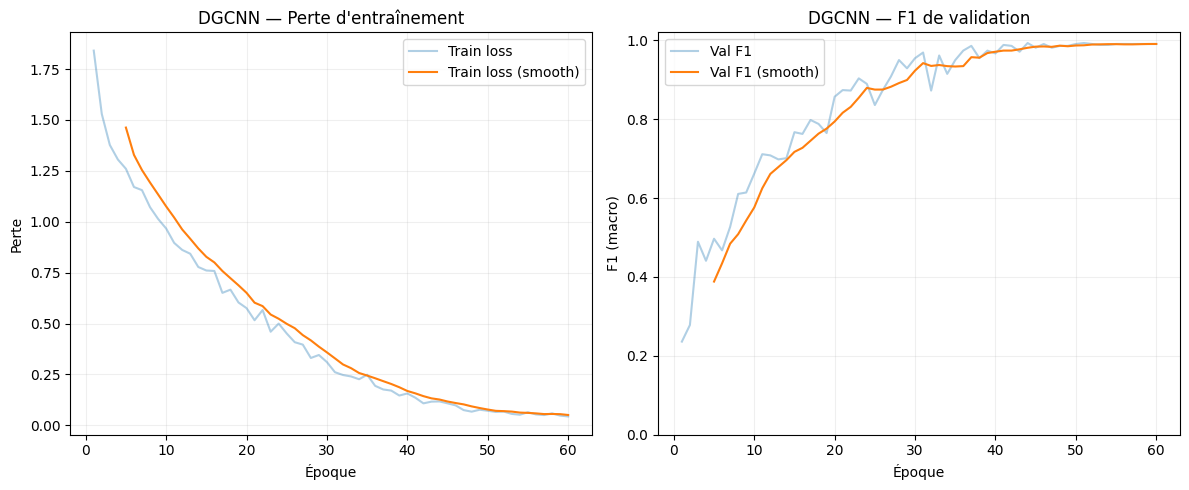

💾 dgcnn_learning_curves_from_log.png


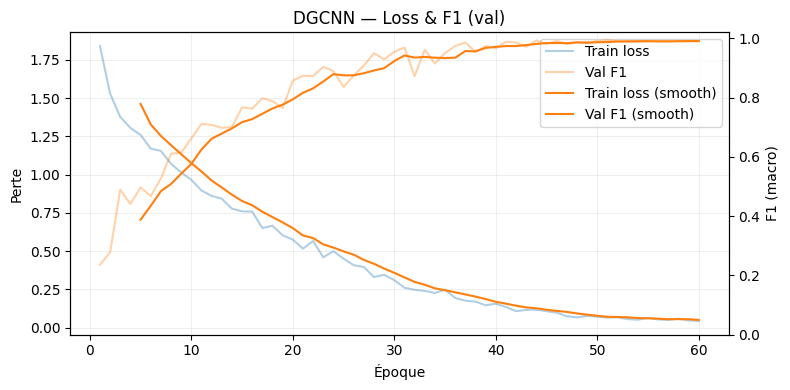

💾 dgcnn_loss_f1_dualaxis.png
⭐ Meilleure F1(val) = 0.9929 à l'époque 44


In [ ]:
# === Courbes DGCNN depuis le log d'entraînement (parse texte) ===
import re, numpy as np, matplotlib.pyplot as plt

LOG = r"""
[001/60] train_loss=1.8406 | val_F1=0.2360
[002/60] train_loss=1.5293 | val_F1=0.2781
[003/60] train_loss=1.3771 | val_F1=0.4892
[004/60] train_loss=1.3057 | val_F1=0.4409
[005/60] train_loss=1.2601 | val_F1=0.4968
[006/60] train_loss=1.1706 | val_F1=0.4673
[007/60] train_loss=1.1551 | val_F1=0.5267
[008/60] train_loss=1.0714 | val_F1=0.6104
[009/60] train_loss=1.0140 | val_F1=0.6140
[010/60] train_loss=0.9669 | val_F1=0.6618
[011/60] train_loss=0.8961 | val_F1=0.7111
[012/60] train_loss=0.8615 | val_F1=0.7081
[013/60] train_loss=0.8427 | val_F1=0.6979
[014/60] train_loss=0.7777 | val_F1=0.7010
[015/60] train_loss=0.7604 | val_F1=0.7669
[016/60] train_loss=0.7581 | val_F1=0.7625
[017/60] train_loss=0.6506 | val_F1=0.7979
[018/60] train_loss=0.6663 | val_F1=0.7878
[019/60] train_loss=0.6033 | val_F1=0.7647
[020/60] train_loss=0.5756 | val_F1=0.8568
[021/60] train_loss=0.5161 | val_F1=0.8736
[022/60] train_loss=0.5661 | val_F1=0.8724
[023/60] train_loss=0.4596 | val_F1=0.9033
[024/60] train_loss=0.4996 | val_F1=0.8894
[025/60] train_loss=0.4510 | val_F1=0.8357
[026/60] train_loss=0.4081 | val_F1=0.8740
[027/60] train_loss=0.3963 | val_F1=0.9080
[028/60] train_loss=0.3307 | val_F1=0.9497
[029/60] train_loss=0.3453 | val_F1=0.9288
[030/60] train_loss=0.3103 | val_F1=0.9545
[031/60] train_loss=0.2607 | val_F1=0.9688
[032/60] train_loss=0.2470 | val_F1=0.8723
[033/60] train_loss=0.2399 | val_F1=0.9613
[034/60] train_loss=0.2262 | val_F1=0.9147
[035/60] train_loss=0.2483 | val_F1=0.9497
[036/60] train_loss=0.1937 | val_F1=0.9738
[037/60] train_loss=0.1760 | val_F1=0.9857
[038/60] train_loss=0.1704 | val_F1=0.9546
[039/60] train_loss=0.1462 | val_F1=0.9736
[040/60] train_loss=0.1563 | val_F1=0.9666
[041/60] train_loss=0.1353 | val_F1=0.9881
[042/60] train_loss=0.1077 | val_F1=0.9857
[043/60] train_loss=0.1162 | val_F1=0.9709
[044/60] train_loss=0.1172 | val_F1=0.9929
[045/60] train_loss=0.1078 | val_F1=0.9810
[046/60] train_loss=0.0979 | val_F1=0.9904
[047/60] train_loss=0.0746 | val_F1=0.9810
[048/60] train_loss=0.0669 | val_F1=0.9856
[049/60] train_loss=0.0764 | val_F1=0.9857
[050/60] train_loss=0.0714 | val_F1=0.9905
[051/60] train_loss=0.0656 | val_F1=0.9929
[052/60] train_loss=0.0673 | val_F1=0.9905
[053/60] train_loss=0.0558 | val_F1=0.9881
[054/60] train_loss=0.0519 | val_F1=0.9881
[055/60] train_loss=0.0640 | val_F1=0.9905
[056/60] train_loss=0.0534 | val_F1=0.9905
[057/60] train_loss=0.0502 | val_F1=0.9904
[058/60] train_loss=0.0585 | val_F1=0.9905
[059/60] train_loss=0.0475 | val_F1=0.9904
[060/60] train_loss=0.0435 | val_F1=0.9905
"""

# extraire epoch, train_loss, val_F1
pat = re.compile(r"\[(\d{3})/(\d+)\]\s+train_loss=([\d\.]+)\s+\|\s+val_F1=([\d\.]+)")
rows = [m.groups() for m in pat.finditer(LOG)]
epochs = np.array([int(e) for e,_,_,_ in rows])
train_loss = np.array([float(tl) for _,_,tl,_ in rows])
val_f1     = np.array([float(f1) for *_,f1 in rows])

assert len(epochs)>0, "Aucune ligne parsée : vérifie le format du log."

# lissage moving average (optionnel)
def smooth(x, k=5):
    if k<=1 or len(x)<k: return x
    return np.convolve(x, np.ones(k)/k, mode="valid")

# 1) Deux sous-graphiques : pertes & F1 (avec et sans lissage)
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(epochs, train_loss, label="Train loss", alpha=0.35)
if len(train_loss)>=5:
    plt.plot(epochs[4:], smooth(train_loss,5), label="Train loss (smooth)")
plt.xlabel("Époque"); plt.ylabel("Perte"); plt.title("DGCNN — Perte d'entraînement")
plt.grid(alpha=0.2); plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs, val_f1, label="Val F1", alpha=0.35)
if len(val_f1)>=5:
    plt.plot(epochs[4:], smooth(val_f1,5), label="Val F1 (smooth)")
plt.xlabel("Époque"); plt.ylabel("F1 (macro)"); plt.title("DGCNN — F1 de validation")
plt.ylim(0, 1.02); plt.grid(alpha=0.2); plt.legend()

plt.tight_layout()
plt.savefig("dgcnn_learning_curves_from_log.png", dpi=300, bbox_inches="tight")
plt.show()
print("💾 dgcnn_learning_curves_from_log.png")

# 2) Une figure combinée avec double axe (loss à gauche, F1 à droite)
fig, ax1 = plt.subplots(figsize=(8,4))
ax2 = ax1.twinx()
l1 = ax1.plot(epochs, train_loss, label="Train loss", alpha=0.35)
if len(train_loss)>=5:
    l1s = ax1.plot(epochs[4:], smooth(train_loss,5), label="Train loss (smooth)")
l2 = ax2.plot(epochs, val_f1, label="Val F1", color="tab:orange", alpha=0.35)
if len(val_f1)>=5:
    l2s = ax2.plot(epochs[4:], smooth(val_f1,5), label="Val F1 (smooth)", color="tab:orange")
ax1.set_xlabel("Époque"); ax1.set_ylabel("Perte"); ax2.set_ylabel("F1 (macro)")
ax1.set_title("DGCNN — Loss & F1 (val)"); ax2.set_ylim(0,1.02)
ax1.grid(alpha=0.2)

# légende combinée
lines = []
for arr in [l1, l2]:
    lines += arr
if len(train_loss)>=5: lines += l1s
if len(val_f1)>=5:   lines += l2s
labs = [ln.get_label() for ln in lines]
ax1.legend(lines, labs, loc="best")

plt.tight_layout()
plt.savefig("dgcnn_loss_f1_dualaxis.png", dpi=300, bbox_inches="tight")
plt.show()
print("💾 dgcnn_loss_f1_dualaxis.png")

# 3) repères : meilleure F1 et époque correspondante
best_ep = int(epochs[val_f1.argmax()])
best_f1 = float(val_f1.max())
print(f"⭐ Meilleure F1(val) = {best_f1:.4f} à l'époque {best_ep}")


**1.Interprétation des courbes d’apprentissage (DGCNN):**
**1. Courbe de perte d’entraînement**

Tendance globale : La perte d’entraînement diminue régulièrement au fil des époques, passant d’une valeur initiale élevée (>1.8) à une valeur très faible (<0.05) vers la fin.

Signification : Cela montre que le modèle apprend efficacement à représenter les données. La descente est progressive, sans stagnation prématurée, indiquant que l’optimisation fonctionne correctement.

Lissage (orange) : la courbe lissée confirme cette tendance monotone et met en évidence une convergence stable.

👉 Conclusion : le modèle ne présente pas de sous-apprentissage (la perte continue de diminuer) et l’optimisation est bien contrôlée (pas de divergence, pas d’oscillations excessives).

**2. Courbe du F1-score de validation**

Phase initiale (0–10 époques) : Le F1 augmente rapidement, passant d’environ 0.23 à 0.70. Cela signifie que le réseau apprend très vite à capturer des structures discriminantes dans les nuages de points.

Phase intermédiaire (10–30 époques) : La progression se poursuit de manière régulière, atteignant ~0.90 vers l’époque 25–30.

Phase finale (30–60 époques) : Le F1 se stabilise autour de 0.99, avec de petites fluctuations normales dues au bruit des batches. Le lissage (courbe orange) montre une convergence claire et stable.

👉 Conclusion : la généralisation du modèle est excellente. Le fait que la métrique de validation continue d’augmenter parallèlement à la diminution de la perte d’entraînement montre que le modèle ne sur-apprend pas prématurément et atteint une performance presque parfaite sur les données de validation.

**3. Analyse croisée**

Absence d’overfitting : Si le modèle sur-apprenait, on observerait une perte d’entraînement très faible mais un F1 de validation stagnant ou décroissant. Or ici, la perte baisse et le F1 monte jusqu’à 0.99 → bon équilibre.

Stabilité en fin d’entraînement : Les dernières époques (40–60) montrent un plateau avec très peu de variations, ce qui indique que le modèle a atteint sa capacité optimale.

Robustesse : Le maintien d’un F1 proche de 1.0 démontre que le DGCNN a appris des représentations très robustes, bien adaptées à la tâche de classification multi-classes des essences de bois.

# **Comparaison PointNet vs DGCNN (+ SVM-RBF):**

*1) Résultats globaux (Test)*

PointNet : Acc = 0.9304, BalAcc = 0.9304, F1(macro) = 0.9293

DGCNN+SVM : Acc = 0.9946, BalAcc = 0.9946, F1(macro) = 0.9946

Gain DGCNN → +6,53 points de F1 macro (0.9946 − 0.9293) et +6,42 à +6,5 points sur Acc/BalAcc.
Conclusion : DGCNN surpasse nettement PointNet en généralisation sur le test.

*2) Par classe (F1, Test):*
| Classe           | PointNet | DGCNN+SVM | Δ (DGCNN − PN) |
| ---------------- | -------: | --------: | -------------: |
| **beech**        |     0.99 |  **1.00** |      **+0.01** |
| **Red\_Oak**     |     0.85 | **0.987** |     **+0.137** |
| **Ash**          |     0.86 | **0.988** |     **+0.128** |
| **Oak**          |     0.99 |  **1.00** |      **+0.01** |
| **douglas\_fir** |     0.91 | **0.994** |     **+0.084** |
| **spruce**       |     0.93 | **0.994** |     **+0.064** |
| **pine**         |     0.98 |  **1.00** |      **+0.02** |


Les plus gros gains viennent des classes historiquement plus confondues par PointNet :
Red_Oak (+13.7 pts) et Ash (+12.8 pts), puis douglas_fir (+8.4 pts) et spruce (+6.4 pts).

Les essences déjà très bien reconnues par PointNet (beech, oak, pine) sont poussées au presque parfait / parfait.

*3) Dynamique d’apprentissage (validation)*

PointNet (100 époques, early stopping à ~89)

Montée progressive du F1(val) de ~0.31 → ~0.91, puis plateau (0.89–0.91) en fin d’entraînement.

Perte(val) diminue bien mais reste significative (~0.14–0.16) ; pas de collapse, mais saturation visible.

DGCNN (60 époques)

Croissance rapide : F1(val) ~0.24 → 0.99 dès ~40–45 époques, puis stabilisation à ~0.99.

Perte(train) décroît régulièrement jusqu’à ~0.04, sans divergence.

Le couple perte↓ / F1(val)↑ reste aligné → pas d’overfitting perceptible.

Conclusion apprentissage : DGCNN converge plus vite et plus haut, et se stabilise nettement au-dessus de PointNet.

*4) Confusions typiques (observations)*

PointNet : erreurs résiduelles surtout Red_Oak ↔ Ash et douglas_fir ↔ spruce (formes proches).

DGCNN : matrices quasi diagonales ; ces confusions sont largement réduites.

*5) Complexité & pipeline*

PointNet ≈ 0.31 M paramètres (~1.18 MB).

DGCNN (backbone + tête softmax entraînée) ≈ 1.36 M paramètres (~5.18 MB).

La classification finale utilise un SVM-RBF sur les embeddings DGCNN (surcoût mémoire marginal côté modèle, mais CPU/GPU peut être un peu plus coûteux si on recompute les embeddings à la volée).

Lecture : DGCNN est plus lourd que PointNet, mais le gain de performance (+6.5 pts F1) est conséquent.
Pour l’inférence, on peut:

extraire les embeddings une fois,

sérialiser (Z, y) et le SVM,

ou déployer le backbone DGCNN seul + SVM (léger côté classif).

# * Interprétation finale*

Capacité de représentation : l’EdgeConv de DGCNN capture mieux la géométrie locale et les relations de voisinage k-NN, ce que PointNet (plus “global”) exploite moins ; c’est clé pour différencier des essences proches (Red_Oak/Ash, Douglas_fir/Spruce).

Stabilité & marge : la montée continue du F1(val) jusqu’à ~0.99 et la quasi-absence de fluctuations finales indiquent une marge de décision élevée.

Généralisation : l’équilibre Acc = BalAcc proche de 1.0 confirme une performance homogène sur toutes les classes.

Choix recommandé : pour ce dataset de 7 essences (équilibré), DGCNN+SVM est nettement supérieur à PointNet, sans signe d’overfitting et avec une dynamique d’apprentissage plus favorable.